In [1]:
# ================================================================================ #
# =========================== Goolge Colab File Upload =========================== #
# ================================================================================ #

from google.colab import drive
drive.mount('/content/drive')

# 출력값 초기화
from google.colab import output
output.clear()

# 경로 수정
import os
os.chdir("drive/Shareddrives/CAC 1조 summer school")

In [ ]:
# unzip the PDB.zip file
# !unzip ./dataset/pdb_data_no_dups.csv.zip -d ./dataset
# !unzip ./dataset/pdb_data_seq.csv.zip -d ./dataset

In [2]:
import numpy as np
import pandas as pd
import sys, glob2, pathlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# dataset path 설정
PATH = "./dataset/"

df_pdb_char = pd.read_csv(PATH + "pdb_data_no_dups.csv")
df_pdb_seq = pd.read_csv(PATH + "pdb_data_seq.csv")
df_cath = pd.read_csv(PATH + "cath_class.csv")

In [3]:
# data info
print("df_pdb_char : ", len(df_pdb_char))
print("df_pdb_seq : ", len(df_pdb_seq))
print("df_cath : ", len(df_cath))

df_pdb_char :  141401
df_pdb_seq :  467304
df_cath :  80969


In [4]:
df_cath.head()

,domain,class,architecture,topology,superfamily,sequence,len,cls_idx
0,1oaiA00,1,10,8,10,PTLSPEQQEMLQAFSTQSGMNLEWSQKCLQDNNWDYTRSAQAFTHL...,59,0
1,1go5A00,1,10,8,10,PAPTPSSSPVPTLSPEQQEMLQAFSTQSGMNLEWSQKCLQDNNWDY...,69,0
2,3frhA01,1,10,8,10,YPMNINDALTSILASKKYRALCPDTVRRILTEEWGRHKSPKQTVEA...,58,0
3,3friA01,1,10,8,10,NINDALTSILASKKYRALCPDTVRRILTEEWGRHKSPKQTVEAART...,54,0
4,4g3oA00,1,10,8,10,RGSENLYFQGQLNAMAHQIQEMFPQVPYHLVLQDLQLTRSVEITTD...,53,0


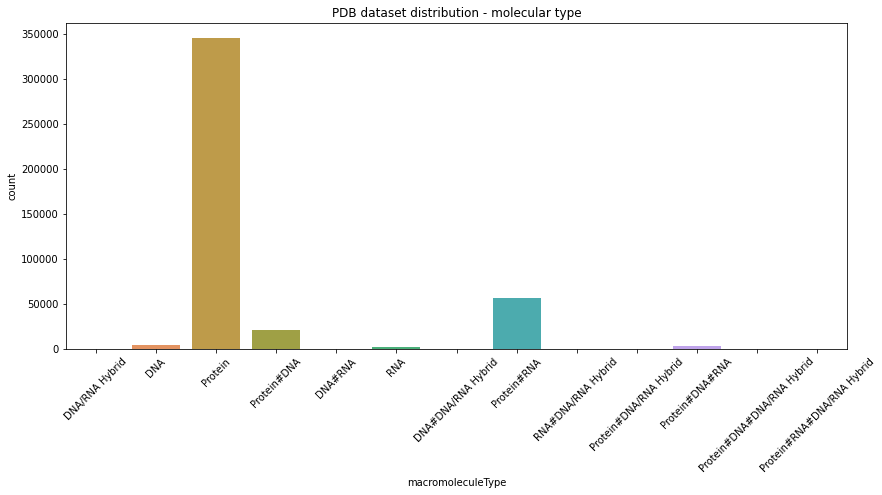

In [5]:
# PDB dataset distribution 
plt.figure(figsize = (14,6))
plt.title("PDB dataset distribution - molecular type")
plt.xticks(rotation = 45)
sns.countplot(data = df_pdb_seq, x = "macromoleculeType")

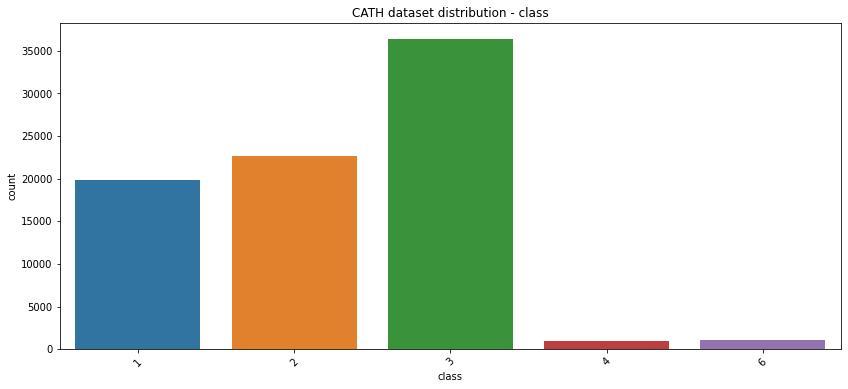

In [6]:
# CATH dataset distribution 
plt.figure(figsize = (14,6))
plt.title("CATH dataset distribution - class")
plt.xticks(rotation = 45)
sns.countplot(data = df_cath, x = "class")

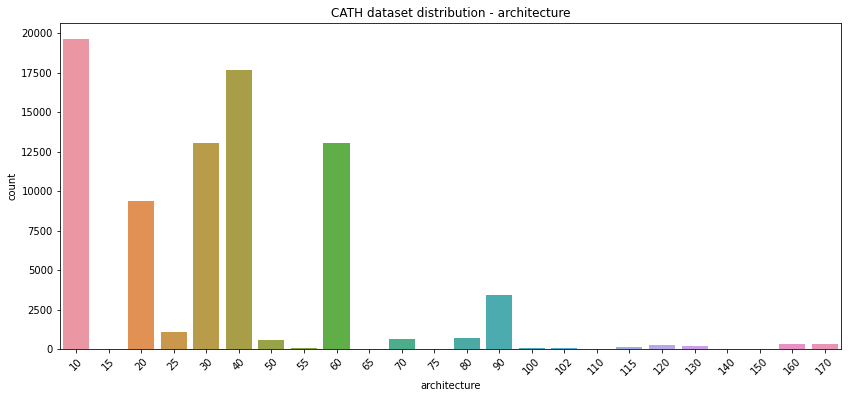

In [7]:
# CATH dataset distribution 
plt.figure(figsize = (14,6))
plt.title("CATH dataset distribution - architecture")
plt.xticks(rotation = 45)
sns.countplot(data = df_cath, x = "architecture")

In [8]:
# select protein class
df_pdb_seq = df_pdb_seq[df_pdb_seq["macromoleculeType"]=="Protein"]
df_pdb_char = df_pdb_char[df_pdb_char["macromoleculeType"] == "Protein"]

In [ ]:
print(df_pdb_char.columns)

Index(['structureId', 'classification', 'experimentalTechnique',
       'macromoleculeType', 'residueCount', 'resolution',
       'structureMolecularWeight', 'crystallizationMethod',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'pdbxDetails', 'phValue', 'publicationYear'],
      dtype='object')


In [9]:
# merge two dataframe
df_pdb_seq.set_index("structureId")
df_pdb_char.set_index("structureId")
df = pd.merge(left = df_pdb_seq, right = df_pdb_char)

In [10]:
# Check NA counts
df.isnull().sum()

structureId                      0
chainId                          2
sequence                         3
residueCount                     0
macromoleculeType                0
classification                   1
experimentalTechnique            0
resolution                   16093
structureMolecularWeight         0
crystallizationMethod       105728
crystallizationTempK        102391
densityMatthews              38844
densityPercentSol            38710
pdbxDetails                  51628
phValue                      87195
publicationYear              50962
dtype: int64

In [11]:
# EDA for PDB dataset
# cols for analysis
cols = [
        "structureId", 
        "residueCount", 
        "sequence", 
        "chainId", 
        "resolution",
        "macromoleculeType", 
        "classification", 
        "structureMolecularWeight",
        "densityMatthews",
        "densityPercentSol",
        "pdbxDetails",
        "phValue"
]

df = df[cols].dropna(axis = 0)
df[["structureId", "sequence", "chainId", "classification", "macromoleculeType"]].head()

,structureId,sequence,chainId,classification,macromoleculeType
0,101M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,A,OXYGEN TRANSPORT,Protein
2,102M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,A,OXYGEN TRANSPORT,Protein
4,103M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,A,OXYGEN TRANSPORT,Protein
7,104M,VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...,A,OXYGEN TRANSPORT,Protein
8,105M,VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...,A,OXYGEN TRANSPORT,Protein


In [ ]:
df[["structureMolecularWeight", "densityMatthews", "densityPercentSol", "phValue"]].head()

,structureMolecularWeight,densityMatthews,densityPercentSol,phValue
0,18112.80,3.09,60.2,9.0
2,18010.64,3.09,60.2,9.0
4,18093.78,3.09,60.3,9.0
7,18030.63,1.87,34.3,7.0
8,18030.63,1.83,33.0,9.0


In [ ]:
print("data : ", len(df))

data :  256044


HYDROLASE                             36278
TRANSFERASE                           29166
OXIDOREDUCTASE                        28486
IMMUNE SYSTEM                         12259
LYASE                                 10188
                                      ...  
TPP BINDING PROTEIN                       1
MEMBRANE PROTEIN, RECEPTOR/Agonist        1
MACROPHAGE SECRETORY PROTEIN              1
Transcription/Hormone                     1
HEXAMERIZATION DOMAIN                     1
Name: classification, Length: 3306, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


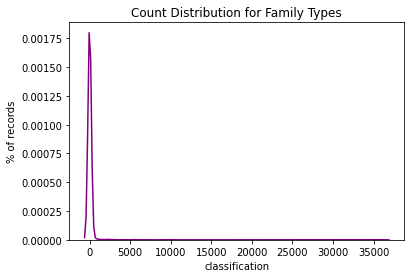

In [12]:
# statistics 
counts = df.classification.value_counts()
print(counts)

# visualize the count distribution for family type
plt.figure()
sns.distplot(counts, hist = False, color = 'purple')
plt.title('Count Distribution for Family Types')
plt.ylabel('% of records')
plt.show()

In [13]:
print("total family type : ", len(counts.keys()))

n_criteria = 5000

effective_counts = counts[counts > n_criteria]
print("effective family type(>{}) : {}".format(n_criteria, len(effective_counts.keys())))

total family type :  3306
effective family type(>5000) : 10


In [ ]:
effective_counts

HYDROLASE                        36278
TRANSFERASE                      29166
OXIDOREDUCTASE                   28486
IMMUNE SYSTEM                    12259
LYASE                            10188
HYDROLASE/HYDROLASE INHIBITOR    10163
TRANSCRIPTION                     6654
TRANSPORT PROTEIN                 5750
ISOMERASE                         5456
VIRAL PROTEIN                     5342
Name: classification, dtype: int64

In [14]:
df.classification = df.classification.apply(lambda x : x if x in effective_counts.keys() else "other")

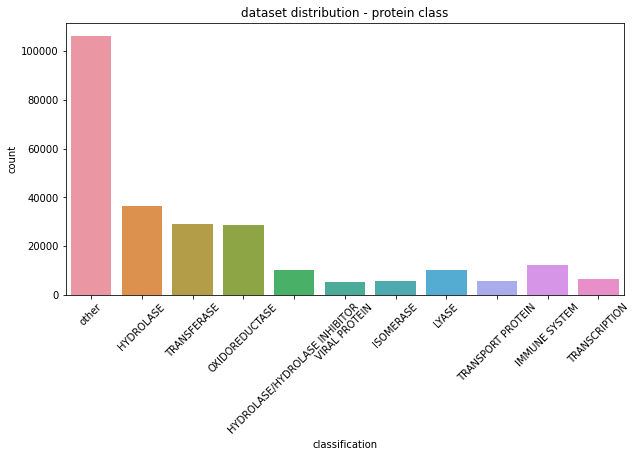

In [15]:
plt.figure(figsize = (10,5))
plt.title("dataset distribution - protein class")
plt.xticks(rotation = 45)
sns.countplot(data = df, x = "classification")

In [16]:
# data filtering : use classes which satisfies n_classes >= n_criteria
# eliminate duplicated data
data = df[df.classification.isin(effective_counts.keys())]
data = data.drop_duplicates(subset=["classification","sequence"])

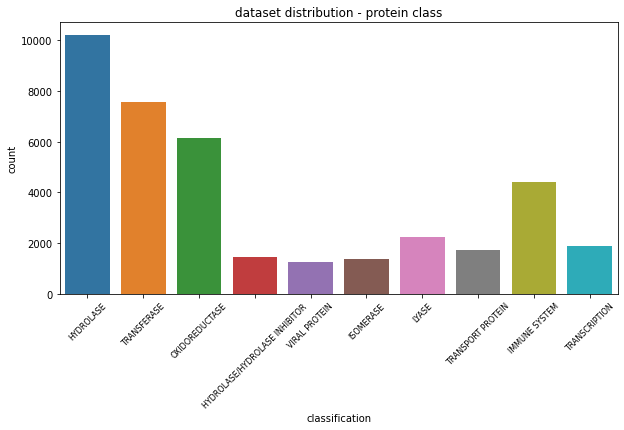

In [17]:
plt.figure(figsize = (10,5))
plt.title("dataset distribution - protein class")
plt.xticks(rotation = 45, fontsize = 8)
sns.countplot(data = data, x = "classification")

classification
HYDROLASE                        AxesSubplot(0.125,0.125;0.775x0.755)
HYDROLASE/HYDROLASE INHIBITOR    AxesSubplot(0.125,0.125;0.775x0.755)
IMMUNE SYSTEM                    AxesSubplot(0.125,0.125;0.775x0.755)
ISOMERASE                        AxesSubplot(0.125,0.125;0.775x0.755)
LYASE                            AxesSubplot(0.125,0.125;0.775x0.755)
OXIDOREDUCTASE                   AxesSubplot(0.125,0.125;0.775x0.755)
TRANSCRIPTION                    AxesSubplot(0.125,0.125;0.775x0.755)
TRANSFERASE                      AxesSubplot(0.125,0.125;0.775x0.755)
TRANSPORT PROTEIN                AxesSubplot(0.125,0.125;0.775x0.755)
VIRAL PROTEIN                    AxesSubplot(0.125,0.125;0.775x0.755)
Name: structureMolecularWeight, dtype: object

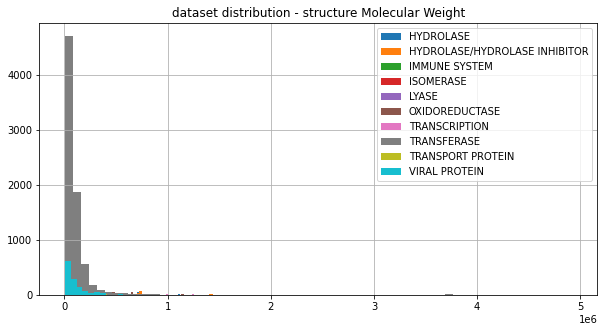

In [18]:
plt.figure(figsize = (10,5))
plt.title("dataset distribution - structure Molecular Weight")
data.groupby('classification')['structureMolecularWeight'].hist(bins = 64, legend = True)

classification
HYDROLASE                        AxesSubplot(0.125,0.125;0.775x0.755)
HYDROLASE/HYDROLASE INHIBITOR    AxesSubplot(0.125,0.125;0.775x0.755)
IMMUNE SYSTEM                    AxesSubplot(0.125,0.125;0.775x0.755)
ISOMERASE                        AxesSubplot(0.125,0.125;0.775x0.755)
LYASE                            AxesSubplot(0.125,0.125;0.775x0.755)
OXIDOREDUCTASE                   AxesSubplot(0.125,0.125;0.775x0.755)
TRANSCRIPTION                    AxesSubplot(0.125,0.125;0.775x0.755)
TRANSFERASE                      AxesSubplot(0.125,0.125;0.775x0.755)
TRANSPORT PROTEIN                AxesSubplot(0.125,0.125;0.775x0.755)
VIRAL PROTEIN                    AxesSubplot(0.125,0.125;0.775x0.755)
Name: densityMatthews, dtype: object

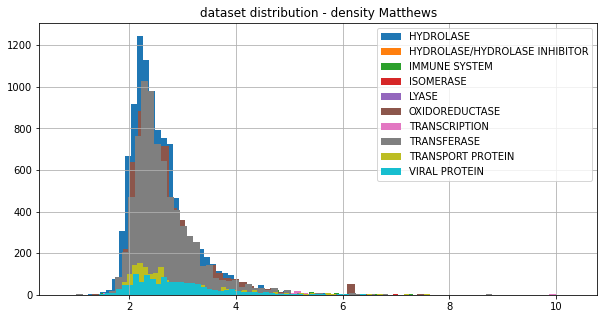

In [ ]:
plt.figure(figsize = (10,5))
plt.title("dataset distribution - density Matthews")
data.groupby('classification')['densityMatthews'].hist(bins = 64, legend = True)

classification
HYDROLASE                        AxesSubplot(0.125,0.125;0.775x0.755)
HYDROLASE/HYDROLASE INHIBITOR    AxesSubplot(0.125,0.125;0.775x0.755)
IMMUNE SYSTEM                    AxesSubplot(0.125,0.125;0.775x0.755)
ISOMERASE                        AxesSubplot(0.125,0.125;0.775x0.755)
LYASE                            AxesSubplot(0.125,0.125;0.775x0.755)
OXIDOREDUCTASE                   AxesSubplot(0.125,0.125;0.775x0.755)
TRANSCRIPTION                    AxesSubplot(0.125,0.125;0.775x0.755)
TRANSFERASE                      AxesSubplot(0.125,0.125;0.775x0.755)
TRANSPORT PROTEIN                AxesSubplot(0.125,0.125;0.775x0.755)
VIRAL PROTEIN                    AxesSubplot(0.125,0.125;0.775x0.755)
Name: densityPercentSol, dtype: object

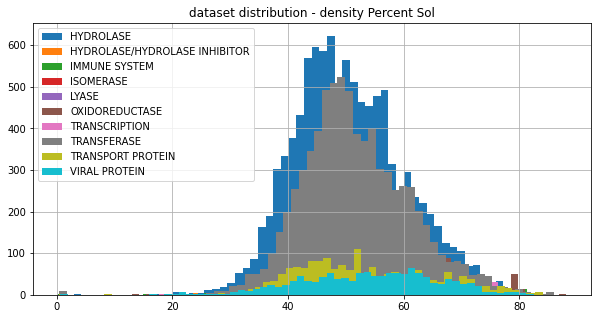

In [ ]:
plt.figure(figsize = (10,5))
plt.title("dataset distribution - density Percent Sol")
data.groupby('classification')['densityPercentSol'].hist(bins = 64, legend = True)

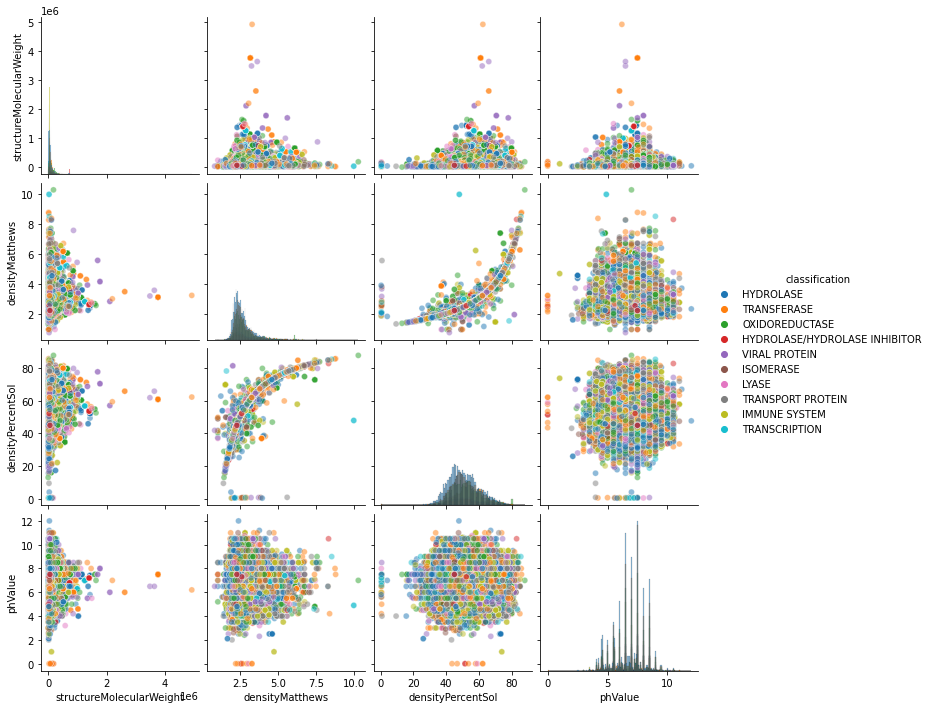

In [ ]:
cols_to_see = [
        "classification", 
        "structureMolecularWeight",
        "densityMatthews",
        "densityPercentSol",
        "phValue"
]

sns.pairplot(
    data[cols_to_see], hue = 'classification', diag_kind= 'hist',
    vars=["structureMolecularWeight","densityMatthews","densityPercentSol","phValue"],
    plot_kws=dict(alpha=0.5), 
    diag_kws=dict(alpha=0.5)
    )

In [ ]:
# 일반적인 chemical properties로는 classification이 어렵다고 판단됨
# 비정형데이터인 sequence 데이터로부터 구조 / 분류 예측 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


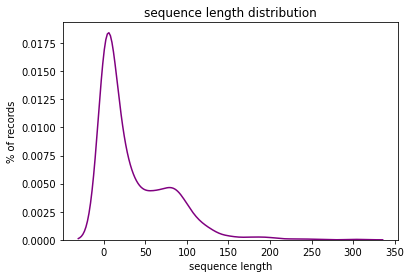

In [19]:
# analysis on sequence data
seq_len_counts = data.sequence.apply(lambda x : len(x)).value_counts()

plt.figure()
sns.distplot(seq_len_counts, hist = False, color = 'purple', axlabel = "sequence length")
plt.title('sequence length distribution')
plt.ylabel('% of records')
plt.show()

In [20]:
# function for n_grams split 
def char_grams(text,n=3,jump_size=2):
    return [text[i:i+n] for i in range(0,len(text)-n+1,jump_size)]

data['3_grams'] = data['sequence'].apply(lambda x : char_grams(x, 3, 2))
data['4_grams'] = data['sequence'].apply(lambda x : char_grams(x, 4, 3))
data['5_grams'] = data['sequence'].apply(lambda x : char_grams(x, 5, 4))

In [21]:
# class to label
counts = data.classification.value_counts()
cls_names = counts.keys().values

class2label = {}
label2class = {}

for idx, name in enumerate(cls_names):
    class2label[name] = idx
    label2class[idx] = name

def ConvertLabel2Class(x : int):
    cls = label2class[x]
    return cls

def ConvertClass2Label(x : str):
    label = class2label[x]
    return label

In [ ]:
cls_names

array(['HYDROLASE', 'TRANSFERASE', 'OXIDOREDUCTASE', 'IMMUNE SYSTEM',
       'LYASE', 'TRANSCRIPTION', 'TRANSPORT PROTEIN',
       'HYDROLASE/HYDROLASE INHIBITOR', 'ISOMERASE', 'VIRAL PROTEIN'],
      dtype=object)

In [22]:
data['cls_idx'] = data['classification'].apply(lambda x : ConvertClass2Label(x))

In [23]:
import random
import re

from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(data, test_size = 0.2, random_state = 42)

# Count Vectorizer application
vec_1gram = CountVectorizer(analyzer = 'char_wb', ngram_range = (2,2))
vec_2gram = CountVectorizer(analyzer = 'char_wb', ngram_range = (3,3))
vec_3gram = CountVectorizer(analyzer = 'char_wb', ngram_range = (4,4))

# fit and transform count vectorizer
vec_1gram.fit(df_train['sequence'])
vec_2gram.fit(df_train['sequence'])
vec_3gram.fit(df_train['sequence'])

CountVectorizer(analyzer='char_wb', ngram_range=(4, 4))

In [24]:
# train, valid, test data generation : n-gram
x_train_1gram = vec_1gram.transform(df_train['sequence'])
x_test_1gram = vec_1gram.transform(df_test['sequence'])

x_train_2gram = vec_2gram.transform(df_train['sequence'])
x_test_2gram = vec_2gram.transform(df_test['sequence'])

x_train_3gram = vec_3gram.transform(df_train['sequence'])
x_test_3gram = vec_3gram.transform(df_test['sequence'])

In [25]:
print("number of 1-gram token : ", len(vec_1gram.get_feature_names()))
print("number of 2-gram token : ", len(vec_2gram.get_feature_names()))
print("number of 3-gram token : ", len(vec_3gram.get_feature_names()))

number of 1-gram token :  538
number of 2-gram token :  9556
number of 3-gram token :  168456


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [26]:
y_train, y_test = df_train['cls_idx'],  df_test['cls_idx']

In [27]:
print("x_1gram.shape : ", x_train_1gram.shape)
print("x_2gram.shape : ", x_train_2gram.shape)
print("x_3gram.shape : ", x_train_3gram.shape)

x_1gram.shape :  (30617, 538)
x_2gram.shape :  (30617, 9556)
x_3gram.shape :  (30617, 168456)


In [28]:
# function for training and ploting curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    if axes is None:
        _, axes = plt.subplots(1,1, figsize=(20, 5))

    axes.set_title(title)

    axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring = "f1_macro"
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes.legend(loc="best")

    return plt

In [29]:
# experiment for several machine learning algorithm
# x_train = sparse matrix, so we have to choose ml models for sparsitiy 
'''
(1) Logistic Regression
(2) PassiveAggressiveClassifier
(3) KNeighborsClassifier
(4) NearestCentroid
(5) MultinomialNB
(6) DecisionTreeClassifier
(7) RandomForestClassifier
(8) AdaBoostClassifier
(9) MLPClassifier
(10) BernoulliNB
(11) SGDClassifier
'''
# models : RandomForest, 

from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# for 1gram dataset

rf = RandomForestClassifier(n_estimators = 128)
nb = MultinomialNB()
nc = NearestCentroid()
ac = AdaBoostClassifier()
sgd = SGDClassifier()
bnb = BernoulliNB()
dtc = DecisionTreeClassifier()

# cross validation
cv = ShuffleSplit(n_splits=8, test_size=0.2, random_state=0)

# f1 score list
f1_scores = {}

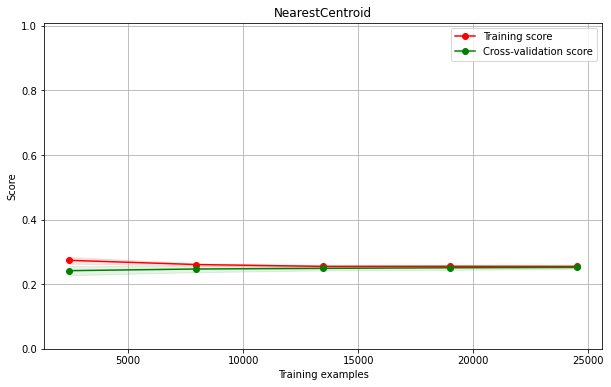

f1 score :  0.254271343029162


In [31]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
title = "NearestCentroid"

plot_learning_curve(
    nc, title, x_train_1gram, y_train, axes=axes, ylim=(0.0, 1.01), cv=cv, n_jobs=-1
)
plt.show()

nc.fit(x_train_1gram, y_train)
pred = nc.predict(x_test_1gram)
print("f1 score : ", f1_score(pred, y_test, average ="macro"))

f1_scores[title] = f1_score(pred, y_test, average ="macro")

############### Classification Report ####################
              precision    recall  f1-score   support

           0       0.44      0.09      0.15      2055
           1       0.49      0.25      0.33      1521
           2       0.30      0.42      0.35      1212
           3       0.81      0.57      0.67       912
           4       0.18      0.19      0.19       429
           5       0.13      0.73      0.23       365
           6       0.17      0.15      0.16       344
           7       0.09      0.22      0.12       285
           8       0.13      0.15      0.14       278
           9       0.18      0.24      0.21       254

    accuracy                           0.28      7655
   macro avg       0.29      0.30      0.25      7655
weighted avg       0.40      0.28      0.29      7655



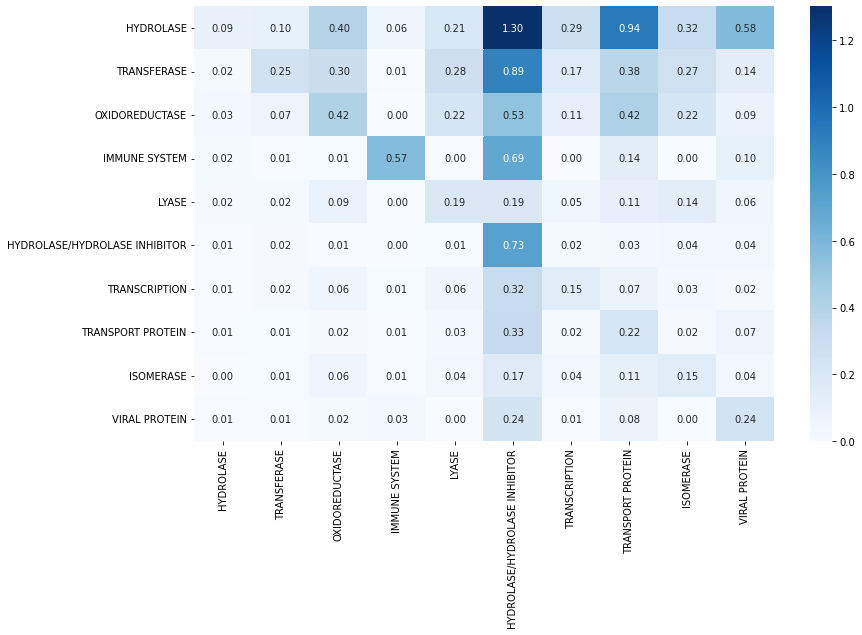

In [32]:
print("############### Classification Report ####################")
print(classification_report(y_test, pred, labels = [i for i in range(len(effective_counts.keys()))]))

conf_mat = confusion_matrix(y_test, pred, labels = [i for i in range(len(effective_counts.keys()))])
fig , ax = plt.subplots()
fig.set_size_inches(13, 8)

sns.heatmap(
        conf_mat / np.sum(conf_mat, axis = 1),
        annot = True,
        fmt = '.2f',
        cmap = 'Blues',
        xticklabels=effective_counts.keys(),
        yticklabels=effective_counts.keys()
    )

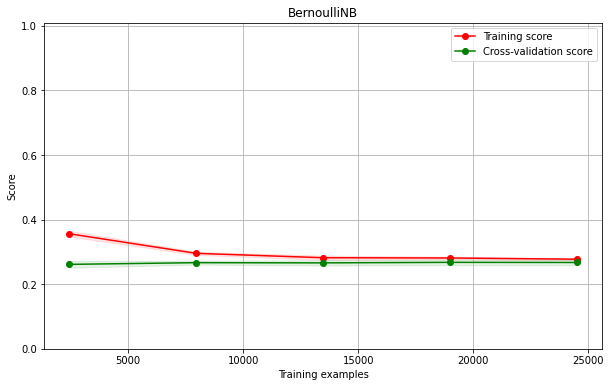

f1 score :  0.26956748075413495


In [33]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
title = "BernoulliNB"

plot_learning_curve(
    bnb, title, x_train_1gram, y_train, axes=axes, ylim=(0.0, 1.01), cv=cv, n_jobs=-1
)
plt.show()

bnb.fit(x_train_1gram, y_train)
pred = bnb.predict(x_test_1gram)
print("f1 score : ", f1_score(pred, y_test, average ="macro"))

f1_scores[title] = f1_score(pred, y_test, average ="macro")

############### Classification Report ####################
              precision    recall  f1-score   support

           0       0.43      0.13      0.20      2055
           1       0.48      0.28      0.36      1521
           2       0.28      0.54      0.37      1212
           3       0.81      0.55      0.65       912
           4       0.21      0.18      0.19       429
           5       0.15      0.61      0.24       365
           6       0.15      0.17      0.16       344
           7       0.14      0.21      0.17       285
           8       0.15      0.17      0.16       278
           9       0.23      0.17      0.19       254

    accuracy                           0.31      7655
   macro avg       0.30      0.30      0.27      7655
weighted avg       0.39      0.31      0.31      7655



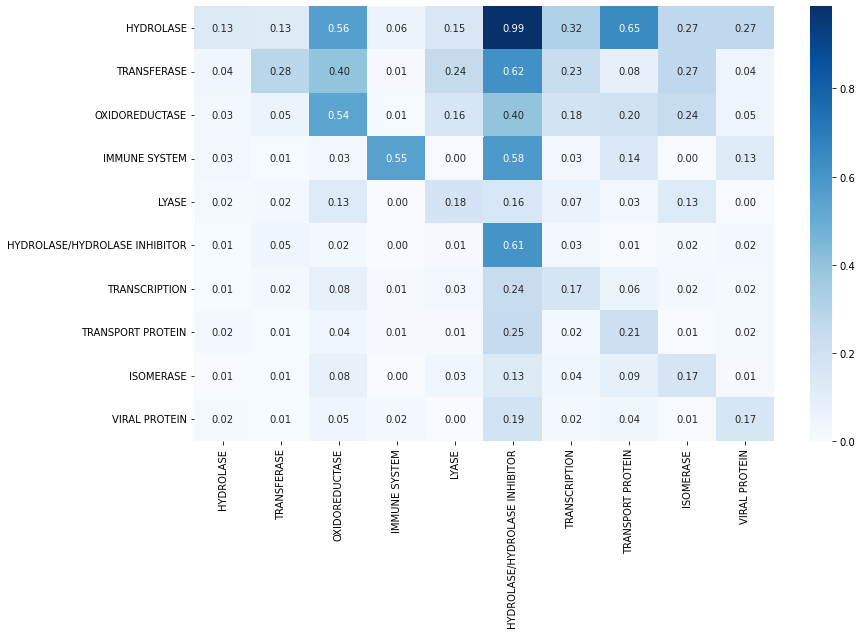

In [34]:
print("############### Classification Report ####################")
print(classification_report(y_test, pred, labels = [i for i in range(len(effective_counts.keys()))]))

conf_mat = confusion_matrix(y_test, pred, labels = [i for i in range(len(effective_counts.keys()))])
fig , ax = plt.subplots()
fig.set_size_inches(13, 8)

sns.heatmap(
        conf_mat / np.sum(conf_mat, axis = 1),
        annot = True,
        fmt = '.2f',
        cmap = 'Blues',
        xticklabels=effective_counts.keys(),
        yticklabels=effective_counts.keys()
    )

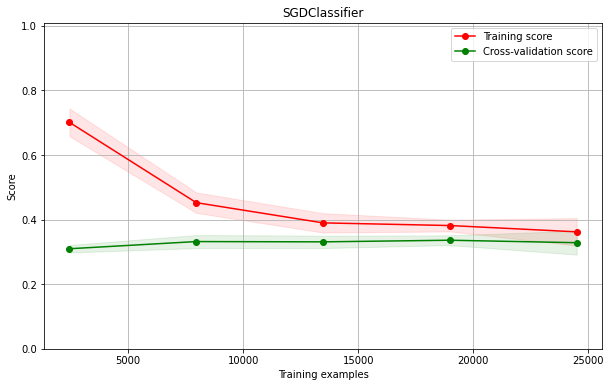

f1 score :  0.36003404561184243


In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
title = "SGDClassifier"

plot_learning_curve(
    sgd, title, x_train_1gram, y_train, axes=axes, ylim=(0.0, 1.01), cv=cv, n_jobs=-1
)
plt.show()

sgd.fit(x_train_1gram, y_train)
pred = sgd.predict(x_test_1gram)
print("f1 score : ", f1_score(pred, y_test, average ="macro"))

f1_scores[title] = f1_score(pred, y_test, average ="macro")

############### Classification Report ####################
              precision    recall  f1-score   support

           0       0.47      0.54      0.50      2055
           1       0.45      0.39      0.42      1521
           2       0.53      0.29      0.37      1212
           3       0.73      0.79      0.76       912
           4       0.23      0.30      0.26       429
           5       0.41      0.12      0.19       365
           6       0.25      0.37      0.30       344
           7       0.17      0.27      0.21       285
           8       0.18      0.29      0.22       278
           9       0.38      0.37      0.38       254

    accuracy                           0.43      7655
   macro avg       0.38      0.37      0.36      7655
weighted avg       0.45      0.43      0.43      7655



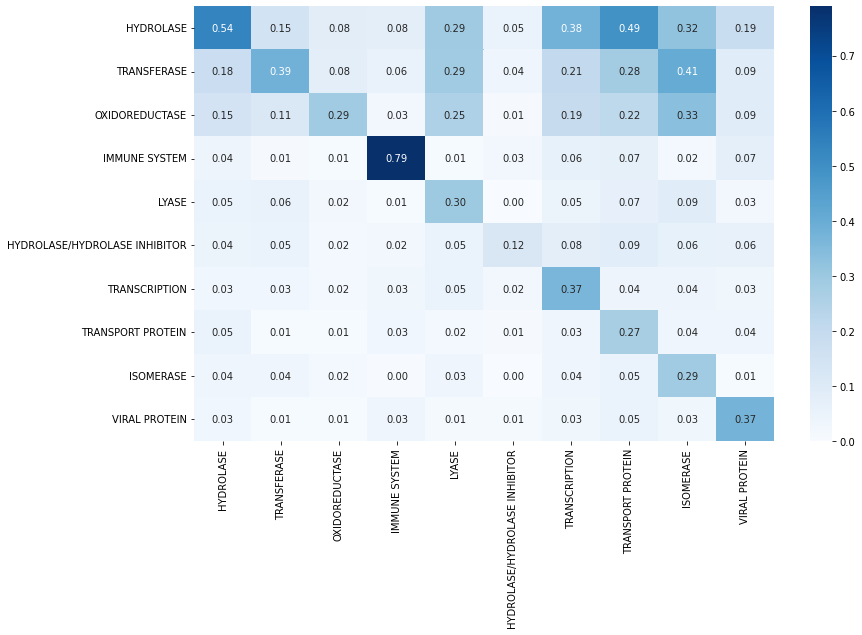

In [ ]:
print("############### Classification Report ####################")
print(classification_report(y_test, pred, labels = [i for i in range(len(effective_counts.keys()))]))

conf_mat = confusion_matrix(y_test, pred, labels = [i for i in range(len(effective_counts.keys()))])
fig , ax = plt.subplots()
fig.set_size_inches(13, 8)

sns.heatmap(
        conf_mat / np.sum(conf_mat, axis = 1),
        annot = True,
        fmt = '.2f',
        cmap = 'Blues',
        xticklabels=effective_counts.keys(),
        yticklabels=effective_counts.keys()
    )

In [ ]:
dtc.fit(x_train_1gram,y_train)
pred = dtc.predict(x_test_1gram)
title = "DecisionTreeClassifier"
print("f1 score : ", f1_score(pred, y_test, average ="macro"))  
f1_scores[title] = f1_score(pred, y_test, average ="macro")

f1 score :  0.5121043333317832


############### Classification Report ####################
              precision    recall  f1-score   support

           0       0.61      0.61      0.61      2055
           1       0.60      0.57      0.59      1521
           2       0.63      0.63      0.63      1212
           3       0.74      0.76      0.75       912
           4       0.50      0.54      0.52       429
           5       0.41      0.44      0.42       365
           6       0.41      0.41      0.41       344
           7       0.29      0.28      0.28       285
           8       0.45      0.48      0.46       278
           9       0.47      0.43      0.45       254

    accuracy                           0.58      7655
   macro avg       0.51      0.51      0.51      7655
weighted avg       0.58      0.58      0.58      7655



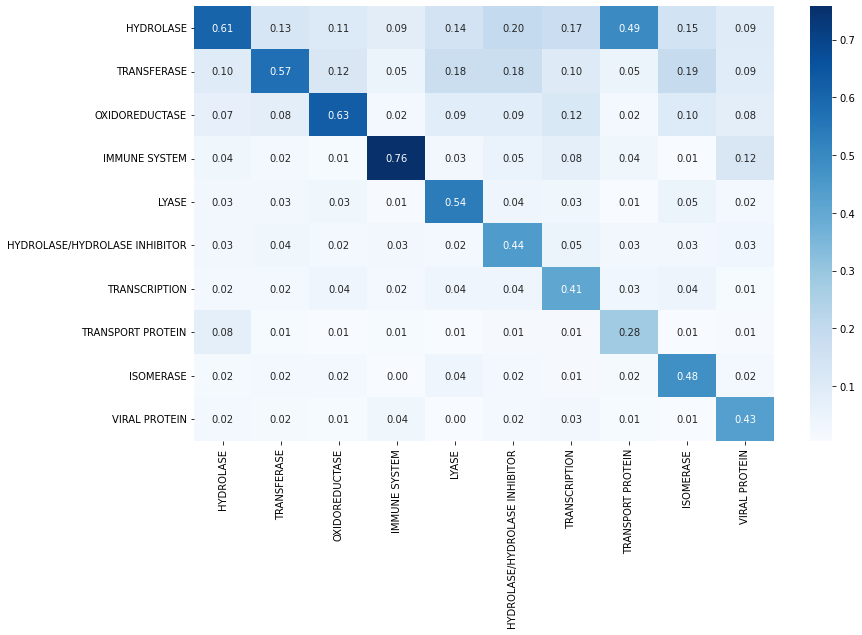

In [ ]:
print("############### Classification Report ####################")
print(classification_report(y_test, pred, labels = [i for i in range(len(effective_counts.keys()))]))

conf_mat = confusion_matrix(y_test, pred, labels = [i for i in range(len(effective_counts.keys()))])
fig , ax = plt.subplots()
fig.set_size_inches(13, 8)

sns.heatmap(
        conf_mat / np.sum(conf_mat, axis = 1),
        annot = True,
        fmt = '.2f',
        cmap = 'Blues',
        xticklabels=effective_counts.keys(),
        yticklabels=effective_counts.keys()
    )

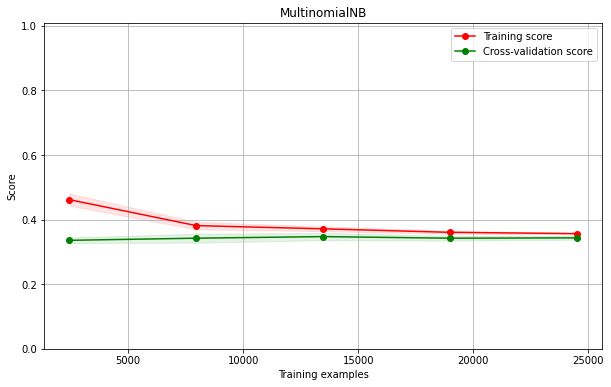

f1 score :  0.35336570603911444


In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
title = "MultinomialNB"

plot_learning_curve(
    nb, title, x_train_1gram, y_train, axes=axes, ylim=(0.0, 1.01), cv=cv, n_jobs=-1
)
plt.show()

nb.fit(x_train_1gram, y_train)
pred = nb.predict(x_test_1gram)
print("f1 score : ", f1_score(pred, y_test, average ="macro"))

f1_scores[title] = f1_score(pred, y_test, average ="macro")

############### Classification Report ####################
              precision    recall  f1-score   support

           0       0.45      0.30      0.36      2055
           1       0.45      0.32      0.37      1521
           2       0.39      0.26      0.31      1212
           3       0.79      0.65      0.71       912
           4       0.21      0.39      0.27       429
           5       0.23      0.55      0.32       365
           6       0.29      0.39      0.33       344
           7       0.25      0.46      0.33       285
           8       0.18      0.31      0.23       278
           9       0.22      0.46      0.30       254

    accuracy                           0.37      7655
   macro avg       0.35      0.41      0.35      7655
weighted avg       0.43      0.37      0.38      7655



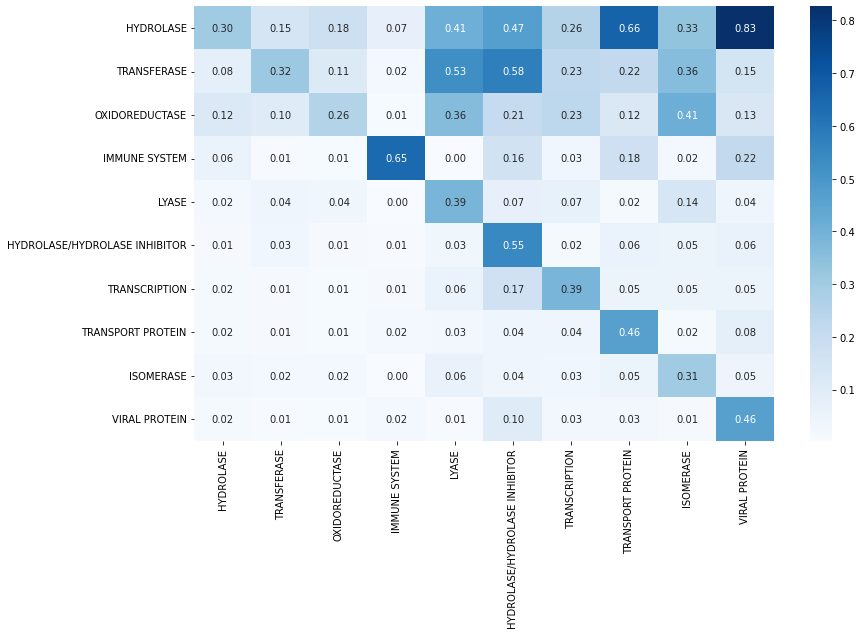

In [ ]:
print("############### Classification Report ####################")
print(classification_report(y_test, pred, labels = [i for i in range(len(effective_counts.keys()))]))

conf_mat = confusion_matrix(y_test, pred, labels = [i for i in range(len(effective_counts.keys()))])
fig , ax = plt.subplots()
fig.set_size_inches(13, 8)

sns.heatmap(
        conf_mat / np.sum(conf_mat, axis = 1),
        annot = True,
        fmt = '.2f',
        cmap = 'Blues',
        xticklabels=effective_counts.keys(),
        yticklabels=effective_counts.keys()
    )

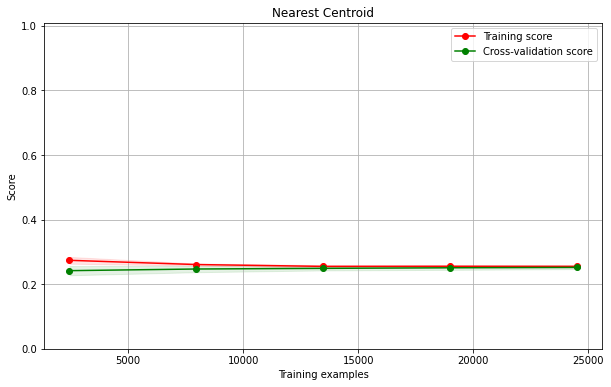

f1 score :  0.254271343029162


In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
title = "Nearest Centroid"

plot_learning_curve(
    nc, title, x_train_1gram, y_train, axes=axes, ylim=(0.0, 1.01), cv=cv, n_jobs=-1
)
plt.show()

nc.fit(x_train_1gram, y_train)
pred = nc.predict(x_test_1gram)
print("f1 score : ", f1_score(pred, y_test, average ="macro"))  

f1_scores[title] = f1_score(pred, y_test, average ="macro")

############### Classification Report ####################
              precision    recall  f1-score   support

           0       0.44      0.09      0.15      2055
           1       0.49      0.25      0.33      1521
           2       0.30      0.42      0.35      1212
           3       0.81      0.57      0.67       912
           4       0.18      0.19      0.19       429
           5       0.13      0.73      0.23       365
           6       0.17      0.15      0.16       344
           7       0.09      0.22      0.12       285
           8       0.13      0.15      0.14       278
           9       0.18      0.24      0.21       254

    accuracy                           0.28      7655
   macro avg       0.29      0.30      0.25      7655
weighted avg       0.40      0.28      0.29      7655



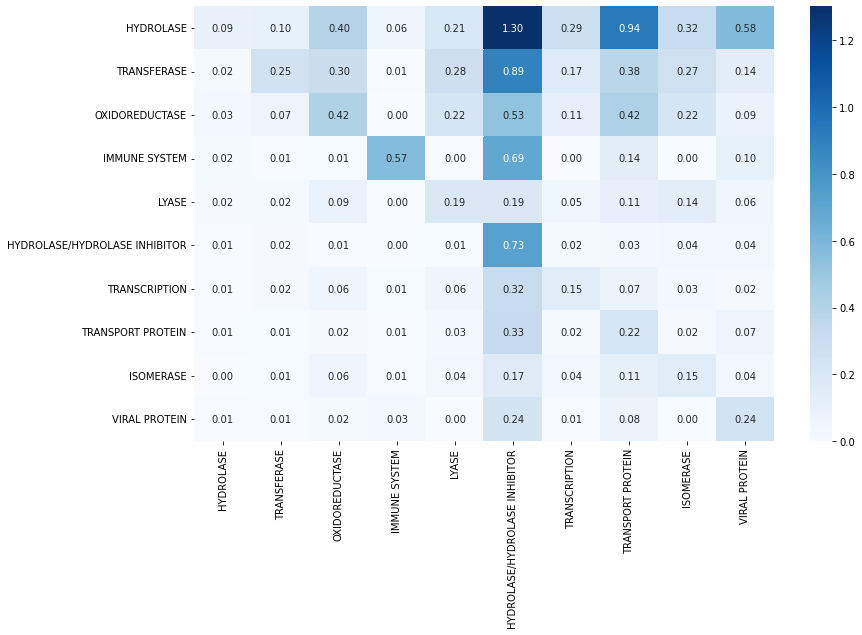

In [ ]:
print("############### Classification Report ####################")
print(classification_report(y_test, pred, labels = [i for i in range(len(effective_counts.keys()))]))

conf_mat = confusion_matrix(y_test, pred, labels = [i for i in range(len(effective_counts.keys()))])
fig , ax = plt.subplots()
fig.set_size_inches(13, 8)

sns.heatmap(
        conf_mat / np.sum(conf_mat, axis = 1),
        annot = True,
        fmt = '.2f',
        cmap = 'Blues',
        xticklabels=effective_counts.keys(),
        yticklabels=effective_counts.keys()
    )

In [ ]:
ac.fit(x_train_1gram,y_train)
pred = ac.predict(x_test_1gram)
title = "AdaBoostClassifier"
print("f1 score : ", f1_score(pred, y_test, average ="macro"))  
f1_scores[title] = f1_score(pred, y_test, average ="macro")

f1 score :  0.2382444420385053


############### Classification Report ####################
              precision    recall  f1-score   support

           0       0.37      0.57      0.45      2055
           1       0.35      0.40      0.37      1521
           2       0.27      0.23      0.25      1212
           3       0.53      0.80      0.64       912
           4       0.33      0.07      0.12       429
           5       0.35      0.13      0.19       365
           6       0.27      0.01      0.02       344
           7       0.44      0.12      0.19       285
           8       0.00      0.00      0.00       278
           9       0.44      0.09      0.16       254

    accuracy                           0.38      7655
   macro avg       0.33      0.24      0.24      7655
weighted avg       0.35      0.38      0.34      7655



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


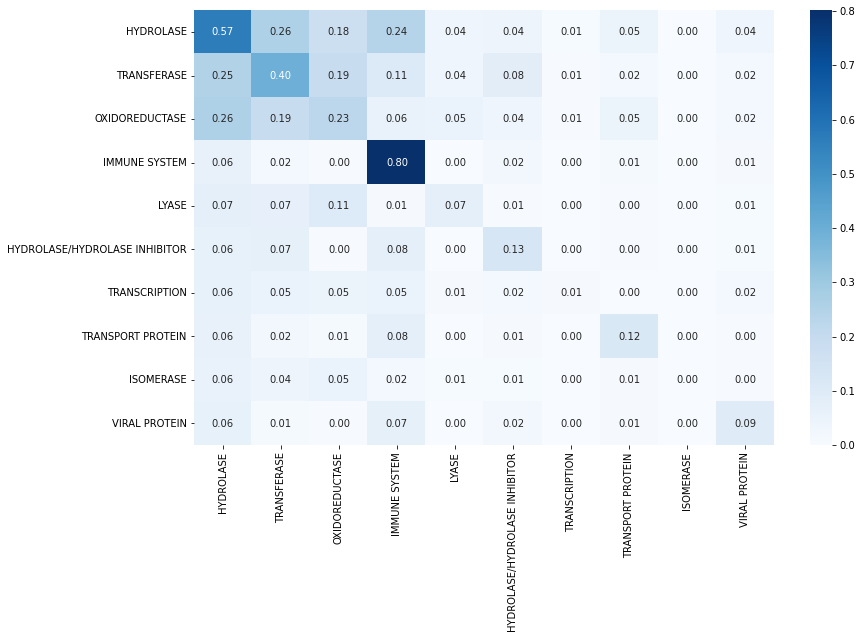

In [ ]:
print("############### Classification Report ####################")
print(classification_report(y_test, pred, labels = [i for i in range(len(effective_counts.keys()))]))

conf_mat = confusion_matrix(y_test, pred, labels = [i for i in range(len(effective_counts.keys()))])
fig , ax = plt.subplots()
fig.set_size_inches(13, 8)

sns.heatmap(
        conf_mat / np.sum(conf_mat, axis = 1),
        annot = True,
        fmt = '.2f',
        cmap = 'Blues',
        xticklabels=effective_counts.keys(),
        yticklabels=effective_counts.keys()
    )

In [ ]:
title = "RandomForest"

rf.fit(x_train_1gram, y_train)
pred = rf.predict(x_test_1gram)

print("f1 score : ", f1_score(pred, y_test, average ="macro"))  
f1_scores[title] = f1_score(pred, y_test, average ="macro")

f1 score :  0.6462183937546235


############### Classification Report ####################
              precision    recall  f1-score   support

           0       0.57      0.80      0.67      2055
           1       0.66      0.71      0.68      1521
           2       0.81      0.70      0.75      1212
           3       0.87      0.85      0.86       912
           4       0.94      0.54      0.68       429
           5       0.78      0.49      0.60       365
           6       0.91      0.40      0.56       344
           7       0.42      0.36      0.39       285
           8       0.92      0.49      0.64       278
           9       0.84      0.49      0.62       254

    accuracy                           0.69      7655
   macro avg       0.77      0.58      0.65      7655
weighted avg       0.72      0.69      0.69      7655



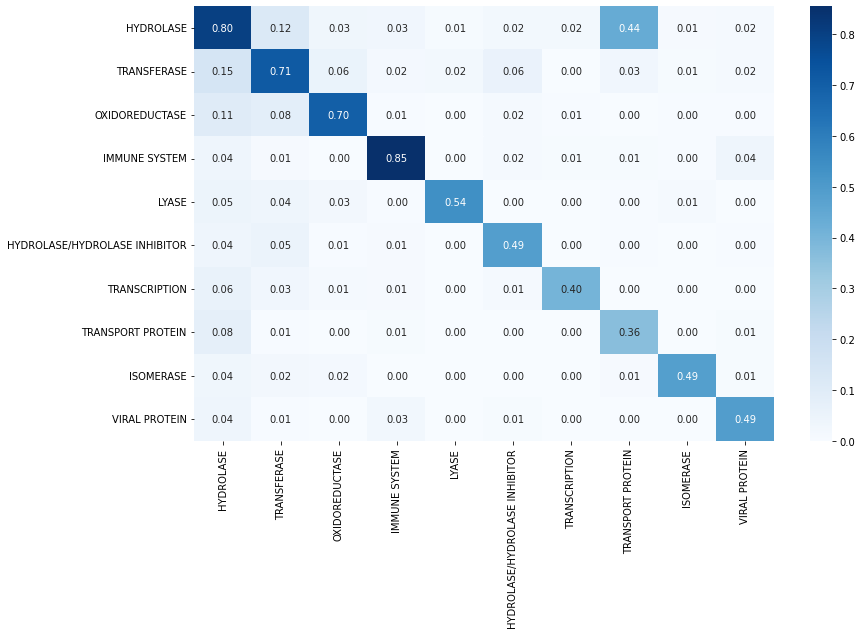

In [ ]:
print("############### Classification Report ####################")
print(classification_report(y_test, pred, labels = [i for i in range(len(effective_counts.keys()))]))

conf_mat = confusion_matrix(y_test, pred, labels = [i for i in range(len(effective_counts.keys()))])
fig , ax = plt.subplots()
fig.set_size_inches(13, 8)

sns.heatmap(
        conf_mat / np.sum(conf_mat, axis = 1),
        annot = True,
        fmt = '.2f',
        cmap = 'Blues',
        xticklabels=effective_counts.keys(),
        yticklabels=effective_counts.keys()
    )

In [ ]:
# comparision
f1_scores

{'AdaBoostClassifier': 0.2382444420385053,
 'BernoulliNB': 0.26956748075413495,
 'DecisionTreeClassifier': 0.5121043333317832,
 'MultinomialNB': 0.35336570603911444,
 'Nearest Centroid': 0.254271343029162,
 'RandomForest': 0.6462183937546235,
 'SGDClassifier': 0.36003404561184243}

In [ ]:
f1_table = pd.DataFrame({
    "Model" : f1_scores.keys().values,
    "f1_score" : f1_scores.values()
})

f1_table

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  import sys


<BarContainer object of 7 artists>

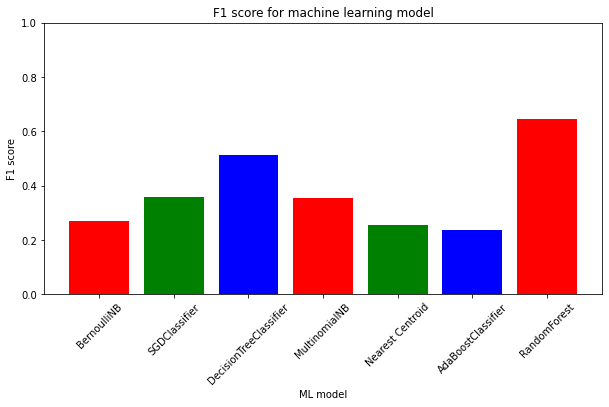

In [ ]:
plt.figure(figsize = (10,5))
plt.title("F1 score for machine learning model")
plt.xticks(rotation = 45, fontsize = 10)
plt.ylim([0,1.0])
plt.xlabel("ML model")
plt.ylabel("F1 score")
plt.bar(f1_scores.keys(), f1_scores.values(), color = 'rgb')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 0, 'Relative Importance')

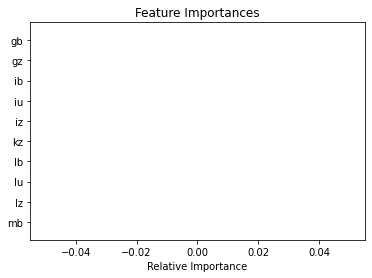

In [ ]:
# random forest importance
importances = rf.feature_importances_
indices = np.argsort(importances)[0:10]

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), np.array(vec_1gram.get_feature_names())[indices])
plt.xlabel('Relative Importance')

In [ ]:
# numerical variables
num_cols = ["densityMatthews","structureMolecularWeight","densityPercentSol","phValue","resolution"]
x_train_num = df_train[num_cols]
x_test_num = df_test[num_cols]

f1_scores = {}

In [ ]:
title = "RandomForest"

rf = RandomForestClassifier(n_estimators = 128)
rf.fit(x_train_num, y_train)
pred = rf.predict(x_test_num)

print("f1 score : ", f1_score(pred, y_test, average ="macro"))  
f1_scores[title] = f1_score(pred, y_test, average ="macro")

f1 score :  0.43388256669028114


############### Classification Report ####################
              precision    recall  f1-score   support

           0       0.43      0.60      0.50      2055
           1       0.41      0.45      0.43      1521
           2       0.43      0.39      0.41      1212
           3       0.66      0.71      0.69       912
           4       0.48      0.22      0.30       429
           5       0.55      0.35      0.43       365
           6       0.60      0.33      0.43       344
           7       0.71      0.47      0.57       285
           8       0.39      0.09      0.14       278
           9       0.61      0.35      0.44       254

    accuracy                           0.47      7655
   macro avg       0.53      0.40      0.43      7655
weighted avg       0.48      0.47      0.46      7655



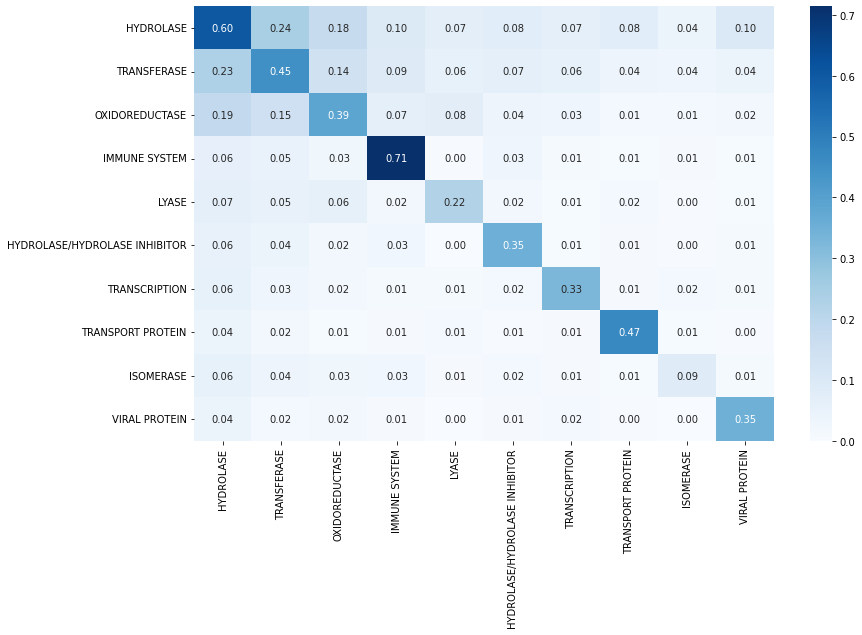

In [ ]:
print("############### Classification Report ####################")
print(classification_report(y_test, pred, labels = [i for i in range(len(effective_counts.keys()))]))

conf_mat = confusion_matrix(y_test, pred, labels = [i for i in range(len(effective_counts.keys()))])
fig , ax = plt.subplots()
fig.set_size_inches(13, 8)

sns.heatmap(
        conf_mat / np.sum(conf_mat, axis = 1),
        annot = True,
        fmt = '.2f',
        cmap = 'Blues',
        xticklabels=effective_counts.keys(),
        yticklabels=effective_counts.keys()
    )

In [ ]:
dtc = DecisionTreeClassifier()
title = "DecisionTreeClassifier"
dtc.fit(x_train_num,y_train)
pred = dtc.predict(x_test_num)
print("f1 score : ", f1_score(pred, y_test, average ="macro")) 
f1_scores[title] = f1_score(pred, y_test, average ="macro") 

f1 score :  0.36949075925412106


############### Classification Report ####################
              precision    recall  f1-score   support

           0       0.47      0.45      0.46      2055
           1       0.37      0.35      0.36      1521
           2       0.36      0.33      0.34      1212
           3       0.59      0.68      0.64       912
           4       0.24      0.27      0.25       429
           5       0.33      0.37      0.35       365
           6       0.33      0.36      0.34       344
           7       0.43      0.49      0.46       285
           8       0.15      0.13      0.14       278
           9       0.35      0.37      0.36       254

    accuracy                           0.41      7655
   macro avg       0.36      0.38      0.37      7655
weighted avg       0.40      0.41      0.40      7655



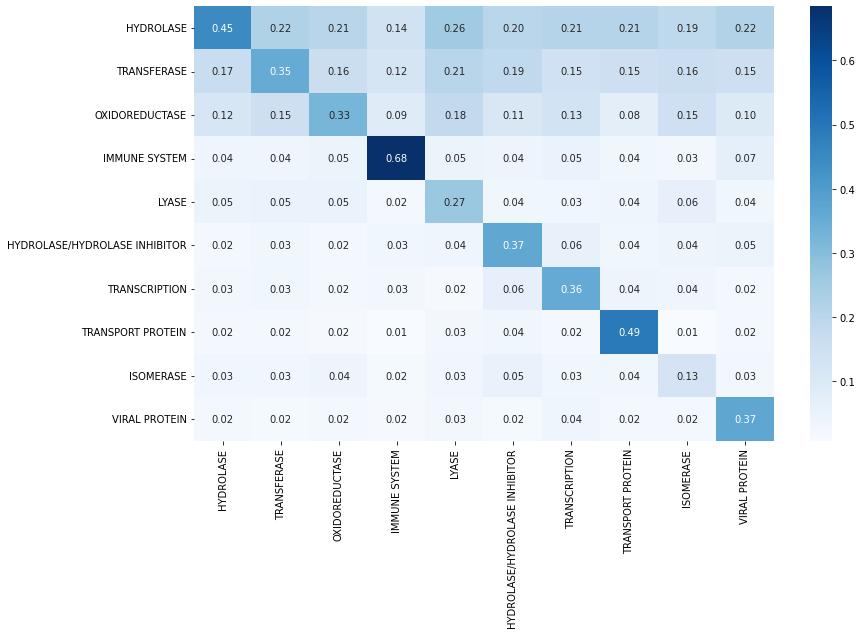

In [ ]:
print("############### Classification Report ####################")
print(classification_report(y_test, pred, labels = [i for i in range(len(effective_counts.keys()))]))

conf_mat = confusion_matrix(y_test, pred, labels = [i for i in range(len(effective_counts.keys()))])
fig , ax = plt.subplots()
fig.set_size_inches(13, 8)

sns.heatmap(
        conf_mat / np.sum(conf_mat, axis = 1),
        annot = True,
        fmt = '.2f',
        cmap = 'Blues',
        xticklabels=effective_counts.keys(),
        yticklabels=effective_counts.keys()
    )

In [ ]:
!pip install xgboost
!pip install lightGBM
output.clear()

In [ ]:
# xgboost and lgbm
import xgboost as xgb
import lightgbm as lgb

In [ ]:
lgb_classifier = lgb.LGBMClassifier()
lgb_classifier.fit(x_train_num, y_train, verbose = True, eval_metric = f1_score)

pred = lgb_classifier.predict(x_test_num)
print("f1 score : ", f1_score(pred, y_test, average ="macro")) 
title = "LightGBM"
f1_scores[title] = f1_score(pred, y_test, average ="macro") 

f1 score :  0.2791851749602717


############### Classification Report ####################
              precision    recall  f1-score   support

           0       0.35      0.65      0.46      2055
           1       0.34      0.35      0.34      1521
           2       0.40      0.29      0.34      1212
           3       0.47      0.53      0.50       912
           4       0.50      0.10      0.16       429
           5       0.45      0.09      0.15       365
           6       0.55      0.15      0.23       344
           7       0.77      0.19      0.31       285
           8       0.62      0.02      0.03       278
           9       0.58      0.17      0.27       254

    accuracy                           0.38      7655
   macro avg       0.50      0.25      0.28      7655
weighted avg       0.43      0.38      0.35      7655



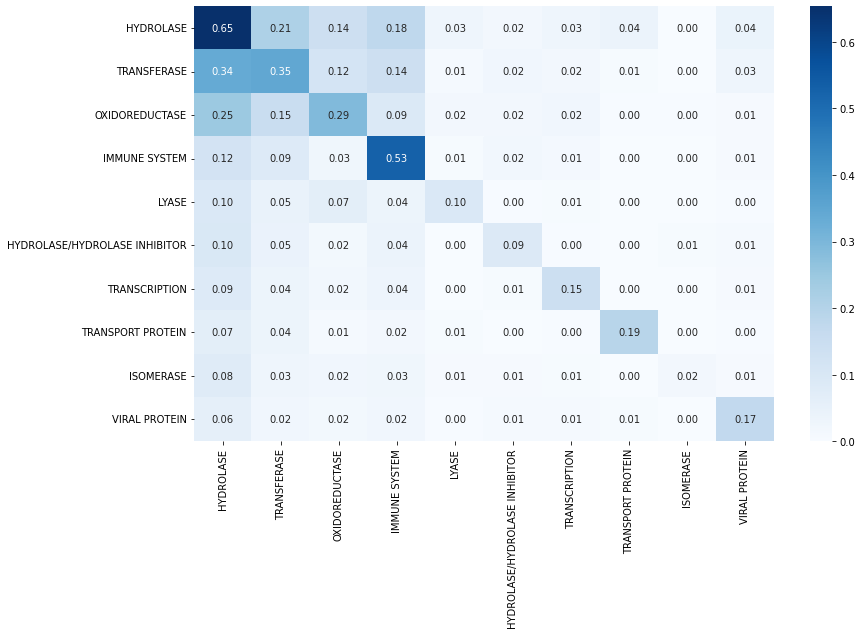

In [ ]:
print("############### Classification Report ####################")
print(classification_report(y_test, pred, labels = [i for i in range(len(effective_counts.keys()))]))

conf_mat = confusion_matrix(y_test, pred, labels = [i for i in range(len(effective_counts.keys()))])
fig , ax = plt.subplots()
fig.set_size_inches(13, 8)

sns.heatmap(
        conf_mat / np.sum(conf_mat, axis = 1),
        annot = True,
        fmt = '.2f',
        cmap = 'Blues',
        xticklabels=effective_counts.keys(),
        yticklabels=effective_counts.keys()
    )

In [ ]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(x_train_num, y_train, verbose = True, eval_metric = f1_score)

pred = xgb_classifier.predict(x_test_num)
print("f1 score : ", f1_score(pred, y_test, average ="macro")) 
title = "XGBoost"
f1_scores[title] = f1_score(pred, y_test, average ="macro") 

f1 score :  0.19888915100674293


############### Classification Report ####################
              precision    recall  f1-score   support

           0       0.34      0.69      0.45      2055
           1       0.32      0.27      0.29      1521
           2       0.33      0.26      0.29      1212
           3       0.44      0.49      0.47       912
           4       0.50      0.00      0.01       429
           5       0.33      0.04      0.08       365
           6       0.33      0.07      0.11       344
           7       0.88      0.11      0.19       285
           8       0.00      0.00      0.00       278
           9       0.42      0.06      0.10       254

    accuracy                           0.35      7655
   macro avg       0.39      0.20      0.20      7655
weighted avg       0.36      0.35      0.30      7655



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


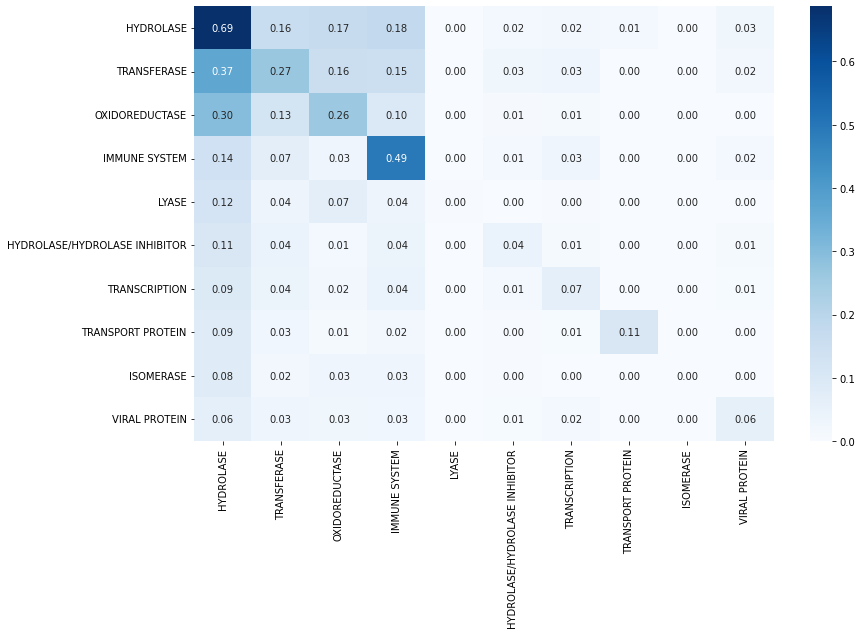

In [ ]:
print("############### Classification Report ####################")
print(classification_report(y_test, pred, labels = [i for i in range(len(effective_counts.keys()))]))

conf_mat = confusion_matrix(y_test, pred, labels = [i for i in range(len(effective_counts.keys()))])
fig , ax = plt.subplots()
fig.set_size_inches(13, 8)

sns.heatmap(
        conf_mat / np.sum(conf_mat, axis = 1),
        annot = True,
        fmt = '.2f',
        cmap = 'Blues',
        xticklabels=effective_counts.keys(),
        yticklabels=effective_counts.keys()
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  import sys


<BarContainer object of 4 artists>

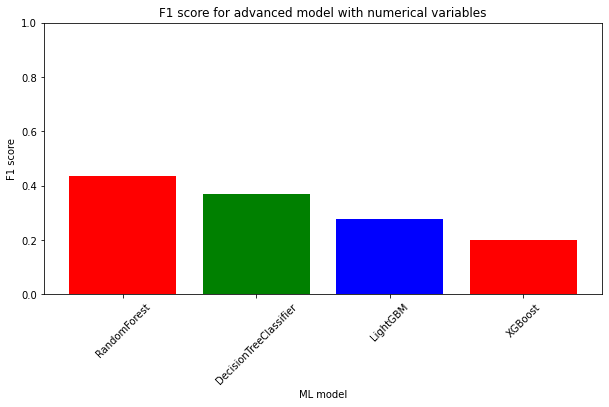

In [ ]:
plt.figure(figsize = (10,5))
plt.title("F1 score for advanced model with numerical variables")
plt.xticks(rotation = 45, fontsize = 10)
plt.ylim([0,1.0])
plt.xlabel("ML model")
plt.ylabel("F1 score")
plt.bar(f1_scores.keys(), f1_scores.values(), color = 'rgb')

In [ ]:
# EDA and check f1 score of ml model for CATH data
df_cath.head()

,domain,class,architecture,topology,superfamily,sequence,len,cls_idx
0,1oaiA00,1,10,8,10,PTLSPEQQEMLQAFSTQSGMNLEWSQKCLQDNNWDYTRSAQAFTHL...,59,0
1,1go5A00,1,10,8,10,PAPTPSSSPVPTLSPEQQEMLQAFSTQSGMNLEWSQKCLQDNNWDY...,69,0
2,3frhA01,1,10,8,10,YPMNINDALTSILASKKYRALCPDTVRRILTEEWGRHKSPKQTVEA...,58,0
3,3friA01,1,10,8,10,NINDALTSILASKKYRALCPDTVRRILTEEWGRHKSPKQTVEAART...,54,0
4,4g3oA00,1,10,8,10,RGSENLYFQGQLNAMAHQIQEMFPQVPYHLVLQDLQLTRSVEITTD...,53,0


In [ ]:
category = np.unique(df_cath.cls_idx.values)

In [ ]:
import random
import re

from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_cath, test_size = 0.2, random_state = 42)

# Count Vectorizer application
vec_1gram = CountVectorizer(analyzer = 'char_wb', ngram_range = (2,2))
vec_2gram = CountVectorizer(analyzer = 'char_wb', ngram_range = (3,3))
vec_3gram = CountVectorizer(analyzer = 'char_wb', ngram_range = (4,4))

# fit and transform count vectorizer
vec_1gram.fit(df_train['sequence'])
vec_2gram.fit(df_train['sequence'])
vec_3gram.fit(df_train['sequence'])

# train, valid, test data generation : n-gram
x_train_1gram = vec_1gram.transform(df_train['sequence'])
x_test_1gram = vec_1gram.transform(df_test['sequence'])

x_train_2gram = vec_2gram.transform(df_train['sequence'])
x_test_2gram = vec_2gram.transform(df_test['sequence'])

x_train_3gram = vec_3gram.transform(df_train['sequence'])
x_test_3gram = vec_3gram.transform(df_test['sequence'])

y_train, y_test = df_train['cls_idx'],  df_test['cls_idx']

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# for 1gram dataset

rf = RandomForestClassifier(n_estimators = 128)
nb = MultinomialNB()
nc = NearestCentroid()
ac = AdaBoostClassifier()
sgd = SGDClassifier()
bnb = BernoulliNB()
dtc = DecisionTreeClassifier()

# cross validation
cv = ShuffleSplit(n_splits=8, test_size=0.2, random_state=0)

# f1 score list
f1_scores = {}

In [ ]:
title = "RandomForest"

rf.fit(x_train_1gram, y_train)
pred = rf.predict(x_test_1gram)

print("f1 score : ", f1_score(pred, y_test, average ="macro"))  
f1_scores[title] = f1_score(pred, y_test, average ="macro")

f1 score :  0.8523612868846338


############### Classification Report ####################
              precision    recall  f1-score   support

           0       0.76      0.91      0.83      2568
           1       1.00      0.78      0.87      1070
           2       1.00      0.78      0.88       237
           3       1.00      0.75      0.86       803
           4       0.92      0.92      0.92      1994
           5       1.00      0.76      0.87       530
           6       0.95      0.79      0.86      1326
           7       1.00      0.78      0.88       773
           8       0.96      0.80      0.87       626
           9       0.76      0.83      0.79      2127
          10       0.74      0.94      0.83      2772
          11       1.00      0.77      0.87       650
          12       1.00      0.74      0.85       335
          13       0.97      0.60      0.74       383

    accuracy                           0.85     16194
   macro avg       0.93      0.80      0.85     16194
weighted avg       0.

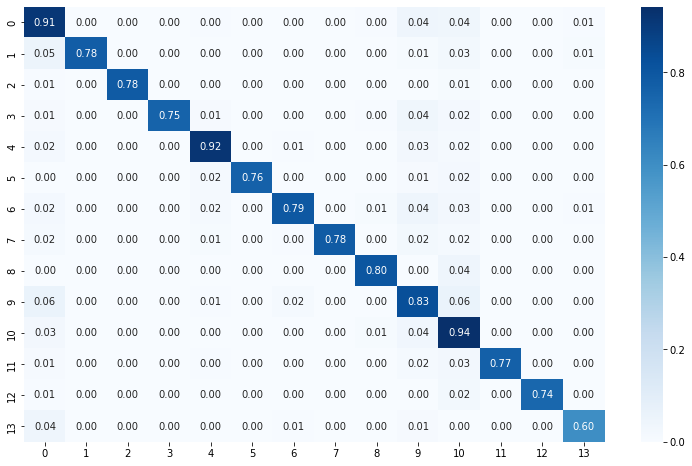

In [ ]:
print("############### Classification Report ####################")
print(classification_report(y_test, pred, labels = [i for i in range(len(category))]))

conf_mat = confusion_matrix(y_test, pred, labels = [i for i in range(len(category))])
fig , ax = plt.subplots()
fig.set_size_inches(13, 8)

sns.heatmap(
        conf_mat / np.sum(conf_mat, axis = 1),
        annot = True,
        fmt = '.2f',
        cmap = 'Blues',
        xticklabels=category,
        yticklabels=category
    )

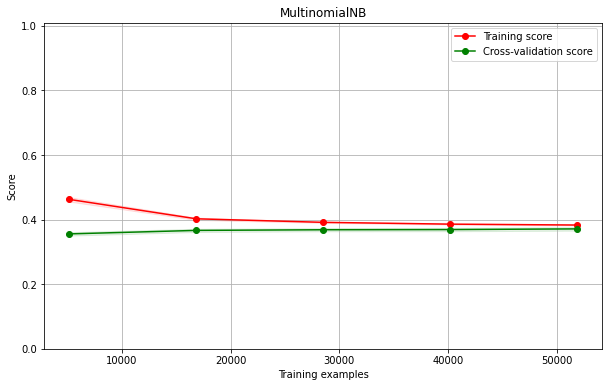

f1 score :  0.3676658155224236


In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
title = "MultinomialNB"

plot_learning_curve(
    nb, title, x_train_1gram, y_train, axes=axes, ylim=(0.0, 1.01), cv=cv, n_jobs=-1
)
plt.show()

nb.fit(x_train_1gram, y_train)
pred = nb.predict(x_test_1gram)
print("f1 score : ", f1_score(pred, y_test, average ="macro"))

f1_scores[title] = f1_score(pred, y_test, average ="macro")

############### Classification Report ####################
              precision    recall  f1-score   support

           0       0.49      0.45      0.47      2568
           1       0.38      0.39      0.39      1070
           2       0.36      0.39      0.37       237
           3       0.32      0.36      0.34       803
           4       0.81      0.58      0.67      1994
           5       0.25      0.48      0.33       530
           6       0.33      0.38      0.35      1326
           7       0.29      0.25      0.27       773
           8       0.38      0.39      0.38       626
           9       0.33      0.33      0.33      2127
          10       0.43      0.46      0.45      2772
          11       0.42      0.19      0.26       650
          12       0.37      0.28      0.32       335
          13       0.17      0.30      0.22       383

    accuracy                           0.41     16194
   macro avg       0.38      0.37      0.37     16194
weighted avg       0.

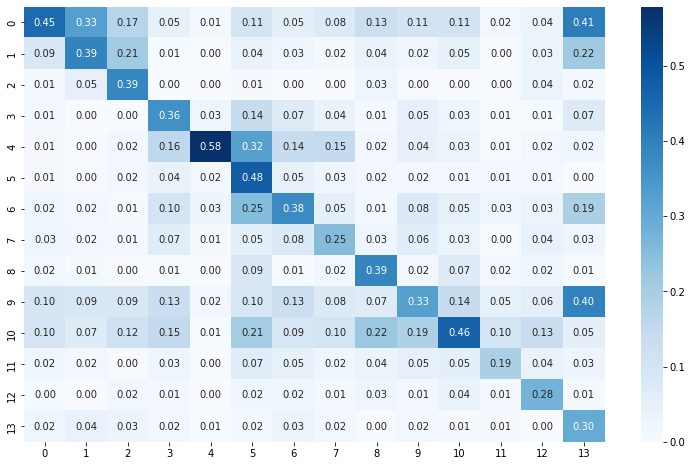

In [ ]:
print("############### Classification Report ####################")
print(classification_report(y_test, pred, labels = [i for i in range(len(category))]))

conf_mat = confusion_matrix(y_test, pred, labels = [i for i in range(len(category))])
fig , ax = plt.subplots()
fig.set_size_inches(13, 8)

sns.heatmap(
        conf_mat / np.sum(conf_mat, axis = 1),
        annot = True,
        fmt = '.2f',
        cmap = 'Blues',
        xticklabels=category,
        yticklabels=category
    )

In [ ]:
title = "DecisionTreeClassifier"

dtc.fit(x_train_1gram, y_train)
pred = dtc.predict(x_test_1gram)

print("f1 score : ", f1_score(pred, y_test, average ="macro"))  
f1_scores[title] = f1_score(pred, y_test, average ="macro")

f1 score :  0.7296793706083979


############### Classification Report ####################
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      2568
           1       0.71      0.75      0.73      1070
           2       0.74      0.74      0.74       237
           3       0.68      0.72      0.70       803
           4       0.84      0.82      0.83      1994
           5       0.71      0.72      0.71       530
           6       0.71      0.73      0.72      1326
           7       0.75      0.72      0.73       773
           8       0.80      0.78      0.79       626
           9       0.71      0.71      0.71      2127
          10       0.80      0.77      0.78      2772
          11       0.72      0.73      0.72       650
          12       0.71      0.72      0.71       335
          13       0.55      0.56      0.55       383

    accuracy                           0.75     16194
   macro avg       0.73      0.73      0.73     16194
weighted avg       0.

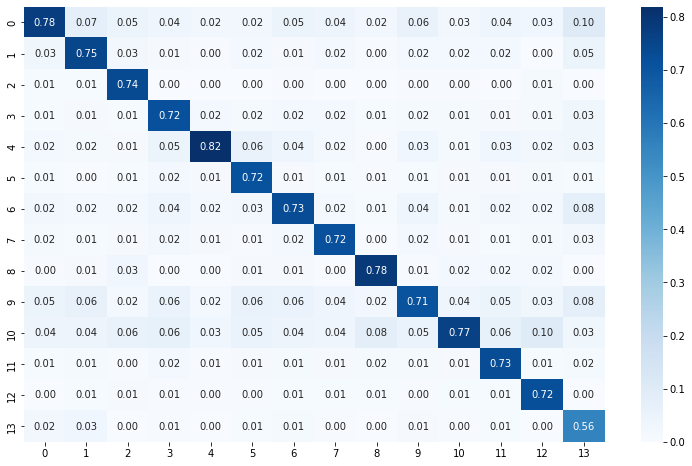

In [ ]:
print("############### Classification Report ####################")
print(classification_report(y_test, pred, labels = [i for i in range(len(category))]))

conf_mat = confusion_matrix(y_test, pred, labels = [i for i in range(len(category))])
fig , ax = plt.subplots()
fig.set_size_inches(13, 8)

sns.heatmap(
        conf_mat / np.sum(conf_mat, axis = 1),
        annot = True,
        fmt = '.2f',
        cmap = 'Blues',
        xticklabels=category,
        yticklabels=category
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  import sys


<BarContainer object of 3 artists>

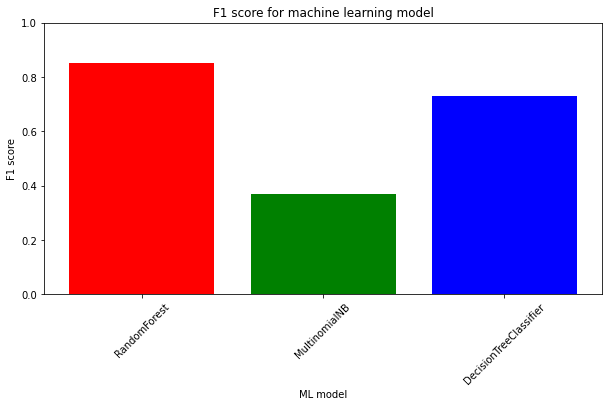

In [ ]:
plt.figure(figsize = (10,5))
plt.title("F1 score for machine learning model")
plt.xticks(rotation = 45, fontsize = 10)
plt.ylim([0,1.0])
plt.xlabel("ML model")
plt.ylabel("F1 score")
plt.bar(f1_scores.keys(), f1_scores.values(), color = 'rgb')

In [35]:
!pip install transformers
output.clear()

In [38]:
# attention based network
# dataset and dataloader

import torch
import torch.nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer
import random
import re

class CustomDataset(Dataset):
    def __init__(self, df, tokenizer, max_len, max_pred, mask_prob):
        super().__init__()
        self.df = df # data
        self.len = len(self.df)
        self.max_pred = max_pred # max tokens of prediction
        self.mask_prob = mask_prob # masking probability
        self.tokenizer = tokenizer # tokenizer
        self.max_len = max_len

    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        item = self.process(item)
        return item
           
    def process(self, row):
        seq = row['sequence'] # 'ACGEF...'
        class_num = row['cls_idx']
        
        # random crop
        if len(seq) >= self.max_len+5:
            idx = random.randint(0,len(seq)-self.max_len-5)
            seq = seq[idx:idx+self.max_len]
        seq = re.sub(r"[UZOB]", "X", seq)
        tokens = list(seq)

        # Tokenize
        ret = self.tokenizer(" ".join(tokens),
                            return_tensors = 'pt',
                            max_length = self.max_len,
                            padding = 'max_length',
                            truncation=True,
                            add_special_tokens=True)
        ret = {k: v.squeeze() for k,v in ret.items()}
        ret['label'] = torch.tensor(class_num)
        return ret
    
    def __len__(self):
        return len(self.df)


from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(data, test_size = 0.2, random_state = 42)
df_train, df_valid = train_test_split(df_train, test_size = 0.3, random_state = 42)

tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
output.clear()

print("train dataset : ", len(df_train))
print("valid dataset : ", len(df_valid))
print("test dataset : ", len(df_test))

# dataloader and input data setting
max_len = 400
max_pred=5
mask_prob=0.15
batch_size=128

# dataset and dataloader 
train_data = CustomDataset(df_train,tokenizer,max_len=max_len,max_pred=max_pred,mask_prob=mask_prob)
valid_data = CustomDataset(df_valid,tokenizer,max_len=max_len,max_pred=max_pred,mask_prob=mask_prob)
test_data = CustomDataset(df_test,tokenizer,max_len=max_len,max_pred=max_pred,mask_prob=mask_prob)

train_loader = DataLoader(train_data, batch_size =batch_size, shuffle = True, num_workers = 4, pin_memory = True)
valid_loader = DataLoader(valid_data, batch_size =batch_size,  shuffle = True, num_workers = 4, pin_memory = True)
test_loader = DataLoader(test_data, batch_size =batch_size, shuffle = True, num_workers = 4, pin_memory = True)

# self-attention network 

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F

class SelfAttention(nn.Module):
	def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length):
		super(SelfAttention, self).__init__()
  
		self.batch_size = batch_size
		self.output_size = output_size
		self.hidden_size = hidden_size
		self.vocab_size = vocab_size
		self.embedding_length = embedding_length

		self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
		self.dropout = 0.5
		self.bilstm = nn.LSTM(embedding_length, hidden_size, dropout=self.dropout, bidirectional=True)
		self.W_s1 = nn.Linear(2*hidden_size, 256)
		self.W_s2 = nn.Linear(256, 32)
		self.fc_layer = nn.Linear(32*2*hidden_size, 512)
		self.label = nn.Linear(512, output_size)

	def attention_net(self, lstm_output):

		attn_weight_matrix = self.W_s2(torch.tanh(self.W_s1(lstm_output)))
		attn_weight_matrix = attn_weight_matrix.permute(0, 2, 1)
		attn_weight_matrix = F.softmax(attn_weight_matrix, dim=2)

		return attn_weight_matrix

	def forward(self, input_sentences, batch_size=None):

		input = self.word_embeddings(input_sentences)
		input = input.permute(1, 0, 2)
		if batch_size is None:
			h_0 = Variable(torch.zeros(2, self.batch_size, self.hidden_size).cuda())
			c_0 = Variable(torch.zeros(2, self.batch_size, self.hidden_size).cuda())
		else:
			h_0 = Variable(torch.zeros(2, batch_size, self.hidden_size).cuda())
			c_0 = Variable(torch.zeros(2, batch_size, self.hidden_size).cuda())

		output, (h_n, c_n) = self.bilstm(input, (h_0, c_0))
		output = output.permute(1, 0, 2)
		attn_weight_matrix = self.attention_net(output)

		hidden_matrix = torch.bmm(attn_weight_matrix, output)
		fc_out = self.fc_layer(hidden_matrix.view(-1, hidden_matrix.size()[1]*hidden_matrix.size()[2]))
		logits = self.label(fc_out)

		return logits

# train and validate process for attention model

from sklearn.metrics import confusion_matrix, classification_report, f1_score
from typing import Optional
from tqdm.auto import tqdm

def train_per_epoch(
    train_loader : torch.utils.data.DataLoader, 
    model : torch.nn.Module,
    optimizer : torch.optim.Optimizer,
    scheduler : Optional[torch.optim.lr_scheduler._LRScheduler],
    loss_fn : torch.nn.Module,
    device : str = "cpu",
    max_norm_grad : float = 1.0
    ):

    model.train()
    model.to(device)

    train_loss = 0
    train_acc = 0

    total_pred = np.array([])
    total_label = np.array([])

    for batch_idx, items in enumerate(train_loader):
        optimizer.zero_grad()
        input_ids, token_ids, att_mask, target = items['input_ids'], items['token_type_ids'], items['attention_mask'], items['label']
        
        input_ids = input_ids.to(device)
        target = target.to(device)

        output = model(input_ids, input_ids.size(0))
        loss = loss_fn(output, target)

        loss.backward()

        # gradient cliping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm_grad)

        optimizer.step()

        train_loss += loss.item()

        pred = torch.nn.functional.softmax(output, dim = 1).max(1, keepdim = True)[1]
        train_acc += pred.eq(target.view_as(pred)).sum().item() / input_ids.size(0) 

        total_pred = np.concatenate((total_pred, pred.cpu().numpy().reshape(-1,)))
        total_label = np.concatenate((total_label, target.cpu().numpy().reshape(-1,)))

    if scheduler:
        scheduler.step()

    train_loss /= (batch_idx + 1)
    train_acc /= (batch_idx + 1)

    train_f1 = f1_score(total_label, total_pred, average = "macro")

    return train_loss, train_acc, train_f1

def valid_per_epoch(
    valid_loader : torch.utils.data.DataLoader, 
    model : torch.nn.Module,
    optimizer : torch.optim.Optimizer,
    loss_fn : torch.nn.Module,
    device : str = "cpu",
    ):

    model.eval()
    model.to(device)
    valid_loss = 0
    valid_acc = 0

    total_pred = np.array([])
    total_label = np.array([])

    for batch_idx, items in enumerate(valid_loader):
        with torch.no_grad():
            optimizer.zero_grad()
            input_ids, token_ids, att_mask, target = items['input_ids'], items['token_type_ids'], items['attention_mask'], items['label']
        
            input_ids = input_ids.to(device)
            target = target.to(device)

            output = model(input_ids, input_ids.size(0))
            loss = loss_fn(output, target)

            valid_loss += loss.item()

            pred = torch.nn.functional.softmax(output, dim = 1).max(1, keepdim = True)[1]
            valid_acc += pred.eq(target.view_as(pred)).sum().item() / input_ids.size(0) 

            total_pred = np.concatenate((total_pred, pred.cpu().numpy().reshape(-1,)))
            total_label = np.concatenate((total_label, target.cpu().numpy().reshape(-1,)))

    valid_loss /= (batch_idx + 1)
    valid_acc /= (batch_idx + 1)
    valid_f1 = f1_score(total_label, total_pred, average = "macro")
 
    return valid_loss, valid_acc, valid_f1

def train(
    train_loader : torch.utils.data.DataLoader, 
    valid_loader : torch.utils.data.DataLoader,
    model : torch.nn.Module,
    optimizer : torch.optim.Optimizer,
    scheduler : Optional[torch.optim.lr_scheduler._LRScheduler],
    loss_fn = None,
    device : str = "cpu",
    num_epoch : int = 64,
    verbose : Optional[int] = 8,
    save_best_only : bool = False,
    save_best_dir : str = "./weights",
    criteria : str = "f1_score",
    max_grad_norm : float = 1.0,
):

    train_loss_list = []
    valid_loss_list = []
    
    train_acc_list = []
    valid_acc_list = []

    train_f1_list = []
    valid_f1_list = []

    best_acc = 0
    best_f1 = 0
    best_epoch = 0
    best_loss = torch.inf

    if loss_fn is None:
        loss_fn = torch.nn.CrossEntropyLoss(reduction = 'mean')

    for epoch in tqdm(range(num_epoch), desc = "training process"):

        train_loss, train_acc, train_f1 = train_per_epoch(
            train_loader, 
            model,
            optimizer,
            scheduler,
            loss_fn,
            device,
            max_grad_norm
        )

        valid_loss, valid_acc, valid_f1 = valid_per_epoch(
            valid_loader, 
            model,
            optimizer,
            loss_fn,
            device 
        )

        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)

        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)

        train_f1_list.append(train_f1)
        valid_f1_list.append(valid_f1)

        if verbose:
            if epoch % verbose == 0:
                print("epoch : {}, train loss : {:.3f}, valid loss : {:.3f}, train acc : {:.3f}, valid acc : {:.3f}, train f1 : {:.3f}, valid f1 : {:.3f}".format(
                    epoch+1, train_loss, valid_loss, train_acc, valid_acc, train_f1, valid_f1
                ))

        if save_best_only:
            if criteria == "f1_score" and best_f1 < valid_f1:
                best_f1 = valid_f1
                best_loss = valid_loss
                best_epoch  = epoch

                if not os.path.exists(save_best_dir):
                    os.mkdir(save_best_dir)

                torch.save(model.state_dict(), save_best_dir + "/best.pt")

            if criteria == "loss" and best_loss > valid_loss:
                best_f1 = valid_f1
                best_loss = valid_loss
                best_epoch  = epoch

                if not os.path.exists(save_best_dir):
                    os.mkdir(save_best_dir)

                torch.save(model.state_dict(), save_best_dir + "/best.pt")

    # print("\n============ Report ==============\n")
    print("training process finished, best loss : {:.3f} and best f1 : {:.3f}, best epoch : {}".format(
        best_loss, best_f1, best_epoch
    ))


    return  train_loss_list, train_acc_list, train_f1_list,  valid_loss_list,  valid_acc_list, valid_f1_list

# attention model training
# device allocation
if(torch.cuda.device_count() >= 1):
    device = "cuda:0" 
else:
    device = 'cpu'

# cache init
torch.cuda.empty_cache()

# model
n_tokens = len(tokenizer.vocab)
embedd_size = 128
hidden_size = 128
num_classes = len(effective_counts.keys())

focal_gamma = 0.5

model = SelfAttention(
    batch_size, 
    output_size = num_classes, 
    hidden_size = hidden_size, 
    vocab_size = n_tokens, 
    embedding_length = embedd_size,
)

# optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

# loss
# loss_fn = torch.nn.CrossEntropyLoss(reduction = "mean")

import torch.nn.functional as F

def compute_focal_loss(inputs:torch.Tensor, gamma:float):
    p = torch.exp(-inputs)
    loss = (1-p) ** gamma * inputs
    return loss.mean()

# focal loss object
class FocalLossLDAM(nn.Module):
    def __init__(self, weight : Optional[torch.Tensor] = None, gamma : float = 0.1):
        super(FocalLossLDAM, self).__init__()
        assert gamma >= 0, "gamma should be positive"
        self.gamma = gamma
        self.weight = weight

    def forward(self, input : torch.Tensor, target : torch.Tensor)->torch.Tensor:
        return compute_focal_loss(F.cross_entropy(input, target, reduction = 'mean', weight = self.weight), self.gamma)


loss_fn = FocalLossLDAM(weight = None, gamma = focal_gamma)

# scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.95)

print("\n################# training process #################\n")
train_loss, train_acc, train_f1, valid_loss, valid_acc, valid_f1 = train(
    train_loader,
    valid_loader,
    model,
    optimizer,
    scheduler,
    loss_fn,
    device,
    num_epoch = 32,
    verbose = 1,
    save_best_only = True,
    save_best_dir = "./pdb_weights",
    criteria = "loss",
    max_grad_norm = 5.0,
)

train dataset :  21431
valid dataset :  9186
test dataset :  7655

################# training process #################



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


training process:   0%|          | 0/32 [00:00<?, ?it/s]

epoch : 1, train loss : 1.592, valid loss : 1.496, train acc : 0.373, valid acc : 0.398, train f1 : 0.209, valid f1 : 0.221
epoch : 2, train loss : 1.457, valid loss : 1.433, train acc : 0.412, valid acc : 0.419, train f1 : 0.254, valid f1 : 0.260
epoch : 3, train loss : 1.377, valid loss : 1.409, train acc : 0.448, valid acc : 0.441, train f1 : 0.300, valid f1 : 0.320
epoch : 4, train loss : 1.297, valid loss : 1.296, train acc : 0.482, valid acc : 0.488, train f1 : 0.354, valid f1 : 0.365
epoch : 5, train loss : 1.164, valid loss : 1.188, train acc : 0.535, valid acc : 0.536, train f1 : 0.431, valid f1 : 0.439
epoch : 6, train loss : 1.040, valid loss : 1.098, train acc : 0.579, valid acc : 0.569, train f1 : 0.490, valid f1 : 0.449
epoch : 7, train loss : 0.907, valid loss : 1.055, train acc : 0.628, valid acc : 0.587, train f1 : 0.543, valid f1 : 0.496
epoch : 8, train loss : 0.770, valid loss : 1.098, train acc : 0.672, valid acc : 0.613, train f1 : 0.600, valid f1 : 0.515
epoch : 

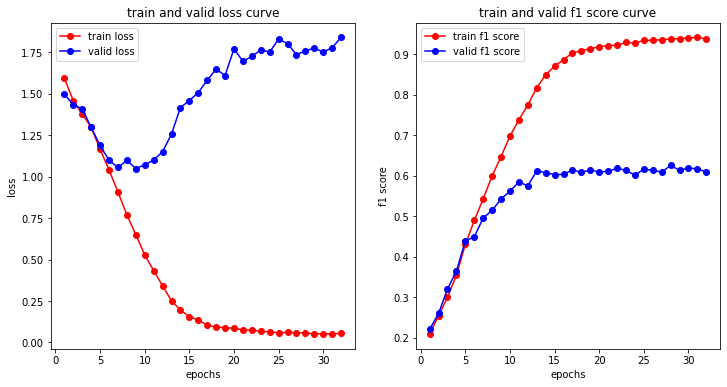

In [39]:
import matplotlib.pyplot as plt

x_epochs = range(1, len(train_loss) + 1)

plt.figure(1, figsize = (12,6))
plt.subplot(1,2,1)
plt.plot(x_epochs, train_loss, 'ro-', label = "train loss")
plt.plot(x_epochs, valid_loss, 'bo-', label = "valid loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("train and valid loss curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(x_epochs, train_f1, 'ro-', label = "train f1 score")
plt.plot(x_epochs, valid_f1, 'bo-', label = "valid f1 score")
plt.xlabel("epochs")
plt.ylabel("f1 score")
plt.title("train and valid f1 score curve")
plt.legend()
plt.show()

In [40]:
def evaluate(
    valid_loader : torch.utils.data.DataLoader, 
    model : torch.nn.Module,
    optimizer : torch.optim.Optimizer,
    loss_fn : torch.nn.Module,
    device : str = "cpu"
    ):

    model.eval()
    model.to(device)
    valid_loss = 0
    valid_acc = 0

    total_pred = np.array([])
    total_label = np.array([])
    
    for batch_idx, items in enumerate(train_loader):
        with torch.no_grad():
            optimizer.zero_grad()
            input_ids, token_ids, att_mask, target = items['input_ids'], items['token_type_ids'], items['attention_mask'], items['label']
            input_ids = input_ids.to(device)
            target = target.to(device)

            output = model(input_ids, input_ids.size(0))
            loss = loss_fn(output, target)

            valid_loss += loss.item()

            pred = torch.nn.functional.softmax(output, dim = 1).max(1, keepdim = True)[1]
            valid_acc += pred.eq(target.view_as(pred)).sum().item() / input_ids.size(0) 

            total_pred = np.concatenate((total_pred, pred.cpu().numpy().reshape(-1,)))
            total_label = np.concatenate((total_label, target.cpu().numpy().reshape(-1,)))

    valid_loss /= (batch_idx + 1)
    valid_acc /= (batch_idx + 1)
    valid_f1 = f1_score(total_label, total_pred, average = "macro")

    conf_mat = confusion_matrix(total_label, total_pred)
    
    print("############### Classification Report ####################")
    print(classification_report(total_label, total_pred, labels = [i for i in range(len(effective_counts.keys()))]))
    print("\n# total test f1 score : {:.2f} and test loss : {:.3f}".format(valid_f1, valid_loss))

    fig , ax = plt.subplots()
    fig.set_size_inches(13, 8)

    sns.heatmap(
            conf_mat / np.sum(conf_mat, axis = 1),
            annot = True,
            fmt = '.2f',
            cmap = 'Blues',
            xticklabels=len(effective_counts.keys()),
            yticklabels=len(effective_counts.keys())
    )
    plt.show()
    
    return valid_loss, valid_acc, f1_score(total_label, total_pred, average = "macro")


# load best weight
model.load_state_dict(torch.load("./weights/pdb_best.pt"), strict = False)

test_loss, test_acc, conf_mat = evaluate(
    test_loader,
    model,
    optimizer,
    loss_fn, 
    device,
)

FileNotFoundError: ignored

In [ ]:
df_train, df_test = train_test_split(df_cath, test_size = 0.2, random_state = 42)
df_train, df_valid = train_test_split(df_train, test_size = 0.3, random_state = 42)

tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
output.clear()

print("train dataset : ", len(df_train))
print("valid dataset : ", len(df_valid))
print("test dataset : ", len(df_test))

# dataloader and input data setting
max_len = 400
max_pred=5
mask_prob=0.15
batch_size=128

# dataset and dataloader 
train_data = CustomDataset(df_train,tokenizer,max_len=max_len,max_pred=max_pred,mask_prob=mask_prob)
valid_data = CustomDataset(df_valid,tokenizer,max_len=max_len,max_pred=max_pred,mask_prob=mask_prob)
test_data = CustomDataset(df_test,tokenizer,max_len=max_len,max_pred=max_pred,mask_prob=mask_prob)

train_loader = DataLoader(train_data, batch_size =batch_size, shuffle = True, num_workers = 4, pin_memory = True)
valid_loader = DataLoader(valid_data, batch_size =batch_size,  shuffle = True, num_workers = 4, pin_memory = True)
test_loader = DataLoader(test_data, batch_size =batch_size, shuffle = True, num_workers = 4, pin_memory = True)

# attention model training
# device allocation
if(torch.cuda.device_count() >= 1):
    device = "cuda:0" 
else:
    device = 'cpu'

# cache init
torch.cuda.empty_cache()

# model
n_tokens = len(tokenizer.vocab)
embedd_size = 128
hidden_size = 128
num_classes = len(category)

focal_gamma = 0.5

model = SelfAttention(
    batch_size, 
    output_size = num_classes, 
    hidden_size = hidden_size, 
    vocab_size = n_tokens, 
    embedding_length = embedd_size,
)

# optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

# loss
# loss_fn = torch.nn.CrossEntropyLoss(reduction = "mean")

loss_fn = FocalLossLDAM(weight = None, gamma = focal_gamma)

# scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.95)

print("\n################# training process #################\n")
train_loss, train_acc, train_f1, valid_loss, valid_acc, valid_f1 = train(
    train_loader,
    valid_loader,
    model,
    optimizer,
    scheduler,
    loss_fn,
    device,
    num_epoch = 32,
    verbose = 1,
    save_best_only = True,
    save_best_dir = "./cath_weights",
    criteria = "loss",
    max_grad_norm = 5.0,
)

In [ ]:
import matplotlib.pyplot as plt

x_epochs = range(1, len(train_loss) + 1)

plt.figure(1, figsize = (12,6))
plt.subplot(1,2,1)
plt.plot(x_epochs, train_loss, 'ro-', label = "train loss")
plt.plot(x_epochs, valid_loss, 'bo-', label = "valid loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("train and valid loss curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(x_epochs, train_f1, 'ro-', label = "train f1 score")
plt.plot(x_epochs, valid_f1, 'bo-', label = "valid f1 score")
plt.xlabel("epochs")
plt.ylabel("f1 score")
plt.title("train and valid f1 score curve")
plt.legend()
plt.show()

In [ ]:
def evaluate(
    valid_loader : torch.utils.data.DataLoader, 
    model : torch.nn.Module,
    optimizer : torch.optim.Optimizer,
    loss_fn : torch.nn.Module,
    device : str = "cpu"
    ):

    model.eval()
    model.to(device)
    valid_loss = 0
    valid_acc = 0

    total_pred = np.array([])
    total_label = np.array([])
    
    for batch_idx, items in enumerate(train_loader):
        with torch.no_grad():
            optimizer.zero_grad()
            input_ids, token_ids, att_mask, target = items['input_ids'], items['token_type_ids'], items['attention_mask'], items['label']
            input_ids = input_ids.to(device)
            target = target.to(device)

            output = model(input_ids, input_ids.size(0))
            loss = loss_fn(output, target)

            valid_loss += loss.item()

            pred = torch.nn.functional.softmax(output, dim = 1).max(1, keepdim = True)[1]
            valid_acc += pred.eq(target.view_as(pred)).sum().item() / input_ids.size(0) 

            total_pred = np.concatenate((total_pred, pred.cpu().numpy().reshape(-1,)))
            total_label = np.concatenate((total_label, target.cpu().numpy().reshape(-1,)))

    valid_loss /= (batch_idx + 1)
    valid_acc /= (batch_idx + 1)
    valid_f1 = f1_score(total_label, total_pred, average = "macro")

    conf_mat = confusion_matrix(total_label, total_pred)
    
    print("############### Classification Report ####################")
    print(classification_report(total_label, total_pred, labels = [i for i in range(len(category))]))
    print("\n# total test f1 score : {:.2f} and test loss : {:.3f}".format(valid_f1, valid_loss))

    fig , ax = plt.subplots()
    fig.set_size_inches(13, 8)

    sns.heatmap(
            conf_mat / np.sum(conf_mat, axis = 1),
            annot = True,
            fmt = '.2f',
            cmap = 'Blues',
            xticklabels=len(category),
            yticklabels=len(category)
    )
    plt.show()
    
    return valid_loss, valid_acc, f1_score(total_label, total_pred, average = "macro")


# load best weight
model.load_state_dict(torch.load("./weights/cath_best.pt"), strict = False)

test_loss, test_acc, conf_mat = evaluate(
    test_loader,
    model,
    optimizer,
    loss_fn, 
    device,
)